In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, utils
import random
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data preprocessing and overview

### dictionary to label left and right

In [194]:
#left = 0, Right = 1, rule out = 2
dic_LR = {
          #TPE part
          'LVOT_Supravalvular_LCC':0,
          'LVOT_Supravalvular_RCC':0,
          'LVOT_Supravalvular_NCC':2,
          'LVOT_Supravalvular_LCC/RCCjunction':0,
          'LVOT_Infravalvular_AMC':0,
          'LVOT_Supravalvular_Septo-parahisian':0,
          'LVOT_Epicardial_AIV/CGV':0,
          'LV_MA':0,
          'LV_PPM_Anterolateral':0,
          'LV_PPM_Posteromedial':0,
          'LV_Crux':0,
          'LV_FascicularVT_Left_posterior_fascicle':0,
          'LV_FascicularVT_Left_anterior_fascicle':0,
          'LV_FascicularVT_Left_upper_septal_fascicle':0,
          'RVOT':1,
          'RV_Parahisian':1,
          'RV_TA':1,
          'RV_PA':1,
          'RV_PPM':1,
          #ZJ part
          'LCC':0,
          'AMC':0,
          'RCC':0,
          'LCC-RCC Ommisure':0,
          'Summit':0,
          'LC':1,
          'RVOTOther':1,
          'PosteriorSeptal':1,
          'AC':1,
          'FreeWall':1,
          'AnteriorSeptal':1,
          'RC':1
}

# Pytorch Data loader

In [3]:
class dataset_screen(Dataset):
    """VPC dataset"""
    def __init__(self, list_data , path_data_folder , dic_label, transform=None):
        """
        Args:
            path_data_folder: data.csv contain ecg signal and lable
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_data = list_data
        self.path_data_folder = path_data_folder
        self.transform = transform
        self.dic_label = dic_label
        
    def __len__(self):
        return len(self.list_data)
    def __getitem__(self, idx):
        
        file_name = self.list_data[idx]
        one_patient_dataframe = pd.read_csv(self.path_data_folder+'\\'+file_name,index_col=False)
        #filter out non-VPC data
        df_VPC = one_patient_dataframe[one_patient_dataframe['wave_type'] == 'VPC']
        str_location = df_VPC['location'].iloc[-1]
        #get list of segment id
        np_list_id = df_VPC['seg_id'].drop_duplicates().to_numpy()
        num_seg = len(np_list_id)
        list_len = []
        #screen through all seg
        for i in range(len(np_list_id)):
            id_seg = np_list_id[i]
            list_len.append(len(one_patient_dataframe[one_patient_dataframe['seg_id'] == id_seg].loc[:,'I':'V6'].index))
        #produce lable
        label = self.dic_label[str_location]
        #print(label,str_location)
        label = torch.tensor(label, dtype = torch.float)
        
        return (list_len , label , str_location, file_name)

In [3]:
#data loader get single wave from .csv file
class VPC_dataset(Dataset):
    """VPC dataset"""
    def __init__(self, list_data , path_data_folder , dic_label, transform=None):
        """
        Args:
            path_data_folder: data.csv contain ecg signal and lable
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_data = list_data
        self.path_data_folder = path_data_folder
        self.transform = transform
        self.dic_label = dic_label
        
    def __len__(self):
        return len(self.list_data)
    def __getitem__(self, idx):
        
        file_name = self.list_data[idx]
        one_patient_dataframe = pd.read_csv(self.path_data_folder+'\\'+file_name,index_col=False)
        str_location = one_patient_dataframe['location'].iloc[-1]

        #produce lable
        label = self.dic_label[str_location]
        label = torch.tensor(label, dtype = torch.long)
        ecg = one_patient_dataframe.loc[:,'I':'V6'].to_numpy()
        ecg = ecg.transpose()
        
        #transform data
        if self.transform:
            ecg = self.transform(ecg)  
        #expend one dim for training 
        ecg = ecg[None,:,:]
        
        return (ecg , label , str_location, file_name)

## Show ECG

In [4]:
#function to show 12 lead ecg all together, input format should be torch tensor
def plot1D_ecg(ecg,title):
    plt.figure(figsize=(20,5))
    for i in range(12):
        plt.subplot(1,12,i+1)
        plt.plot(ecg[i,:])
        plt.xlim([0,1000])
        plt.ylim([-10000,10000])
        plt.axis('off')
    plt.title(title)
    plt.show()
def plot2D_ecg(ecg,title):
    plt.figure(figsize=(5,2))
    plt.title(title)
    plt.imshow(ecg, aspect = 'auto' , interpolation = 'none')

## Data transformer
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [5]:
from skimage import io, transform
from scipy import interpolate

class Random_trimming(object): #randomly chopp off head or tail of an wave
    def __init__(self, max_trim):
        self.max_trim = max_trim #maximal trimming length
    def __call__(self, original_ecg):
        sig_len = np.shape(original_ecg)[1]
        drift = np.random.randint(-self.max_trim,self.max_trim,size = 1)[0]
        
        if drift >=0 :
            drift_result = original_ecg[:,0:sig_len-drift]
        else:
            drift_result = original_ecg[:,abs(drift):sig_len]
        return drift_result


class Add_edge_tail(object):
    
    def __init__(self, sig_len):
        self.sig_len = sig_len
        
    def __call__(self, original_ecg):
        original_len = np.shape(original_ecg)[1]
        #print(np.shape(original_ecg))
        if original_len <= self.sig_len:
            #add zero to signal tail to make the signal into equal length(sig_len), clip the tail if it is too long
            pad_result = np.pad(original_ecg ,((0,0),(0,self.sig_len-original_len)),'edge')
            return pad_result
        else:
            return original_ecg[:,0:self.sig_len]
class Random_drift(object):

    def __init__(self, max_drift):
        self.max_drift = max_drift
        
    def __call__(self, ecg):
        original_len = np.shape(ecg)[1]
        low = -self.max_drift
        high = self.max_drift
        drift = int(np.random.uniform(low,high,1))
        if drift>=0:
            #extend head if drift to right
            drift_result = np.pad(ecg ,( (0,0),  (    0      , abs(drift) )) , 'edge' )
            
            return drift_result
        else:
            #extend head if drift to left
            drift_result = np.pad(ecg ,( (0,0),  (abs(drift) ,      0      )) , 'edge' )
            return drift_result
                                  
class Random_strech(object): # strech the wave to the targe wave length
    def __init__(self,strech_range):
        self.strech_range = strech_range
    def __call__(self, ecg):
        original_len = np.shape(ecg)[1]
        low = self.strech_range[0]
        high = self.strech_range[1]
        target = int(np.random.uniform(low,high,1)[0]*original_len)
        ecg_new = np.zeros((12,target))
        for i in range(12):
            y = ecg[i,:]
            x = np.linspace(0, 1, num = original_len)
            x_new = np.linspace(0, 1, num = target)
            y_new = np.interp(x_new, x, y)
            ecg_new[i,:]=y_new
        return ecg_new
class Strech_to_target(object):
    def __init__(self,target):
        self.target = target
    def __call__(self, ecg):
        ecg_new = np.zeros((12,self.target))
        for i in range(12):
            y = ecg[i,:]
            original_len = np.shape(y)[0]
            x = np.linspace(0, 1, num = original_len)
            x_new = np.linspace(0, 1, num = self.target)
            y_new = np.interp(x_new, x, y)
            ecg_new[i,:]=y_new
        return ecg_new
    
class Random_vertical_drift_tilt(object):#randomly vertical drift ecg leads
    def __init__(self,max_drift,max_tilt):
        self.max_drift = max_drift
        self.max_tilt = max_tilt
    def __call__(self,ecg):
        original_len = np.shape(ecg)[1]
        #random vertical drift
        max_drift = self.max_drift
        drift = np.random.uniform(-max_drift,max_drift,12)
        drift = np.expand_dims(drift, axis=1)
        drift = np.pad(drift,( (0,0) , (0,original_len-1)) ,'edge')
        #random tilt
        max_tilt = self.max_tilt
        tilt = np.random.uniform(-max_tilt,max_tilt,12)
        tilt_matrix = np.transpose(np.linspace(0, tilt, num = original_len))
        
        drift_result = ecg+drift+tilt_matrix
        return drift_result
    
class Random_scale:   # randomly scale individual signal of 12 lead ecg or randomly scale up all leads
    def __init__(self,scale_range_single, scale_range_all):
        self.scale_range_single = scale_range_single
        self.scale_range_all = scale_range_all
    def __call__(self,ecg):
        original_len = np.shape(ecg)[1]
        #scale individual lead signal differently
        scale_range_single = self.scale_range_single
        low_single = scale_range_single[0]
        high_single = scale_range_single[1]
        scale_list = np.random.uniform(low_single,high_single,(12,1))
        scale = np.broadcast_to(scale_list, (12, original_len))
        
        #scale all lead with equal ratio
        scale_range_all = self.scale_range_all 
        low_all = scale_range_all[0]
        high_all = scale_range_all[1]
        scale_all = np.random.uniform(low_all,high_all,1)
        scale = np.multiply(scale,scale_all)
        return np.multiply(ecg,scale)
class Add_noise(object): #add random value to all signal
    def __init__(self,max_noise):
        self.max_noise = max_noise
    def __call__(self,ecg):
        max_noise = self.max_noise
        original_len = np.shape(ecg)[1]
        random_noise = np.random.uniform(-max_noise,max_noise,(12,original_len))
        return ecg+random_noise

class To_torch_tensor(object):
    def __call__(self, np_ecg):
        return torch.tensor(np_ecg, dtype = torch.float)


### test data transformation

In [6]:
path_data = 'E:\\back up2\\Google Drive\\Large Files\\Datasets\\VT_datasets\\VPC2\\test'
list_file = os.listdir(path_data)
data_transform = transforms.Compose([
#         Random_trimming(100),
#         Random_strech([0.8,1.2]),
         #Random_drift(200),
#          Random_scale([1,1],[0.1,0.1]),
         Add_edge_tail(1024),
        #Random_vertical_drift_tilt(0,10000),
        #Add_noise(1000),
        To_torch_tensor(),
    ])
#data transformation
train_data_loader = VPC_dataset( list_file , path_data , dic_LR , transform = data_transform )

torch.Size([1, 12, 1024])


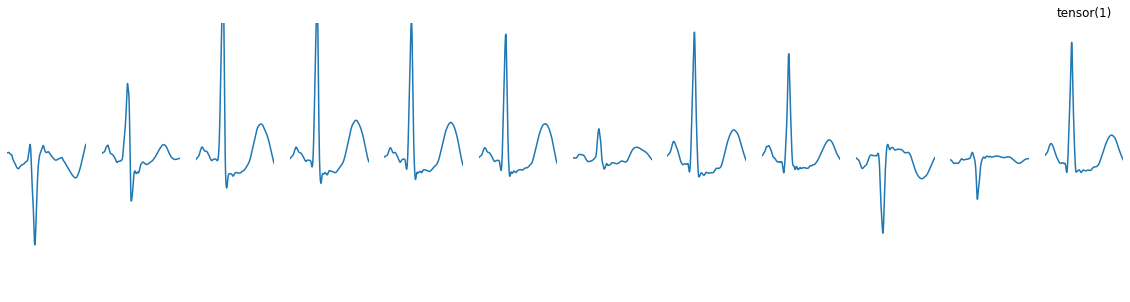

In [7]:
ecg , label , str_location, file_name = train_data_loader[1]
print(ecg.size())
plot1D_ecg(ecg[0,:,:],label)


In [403]:
path_data_TPE = 'C:\\Users\\USER\\Desktop\\VPC\\TPE_only'
list_full_file_TPE = os.listdir(path_data_TPE)
data_transform_TPE = transforms.Compose([
#         Random_trimming(100),
#         Random_strech([0.8,1.2]),
         #Random_drift(200),
         Add_edge_tail(1024),
        #Random_vertical_drift_tilt(0,10000),
        #Add_noise(1000),
        #Random_scale([0.01,10]),
        To_torch_tensor()
    ])
#data transformation
train_data_loader_TPE = VPC_dataset( list_full_file_TPE , path_data_TPE , dic_LR , transform = data_transform_TPE )

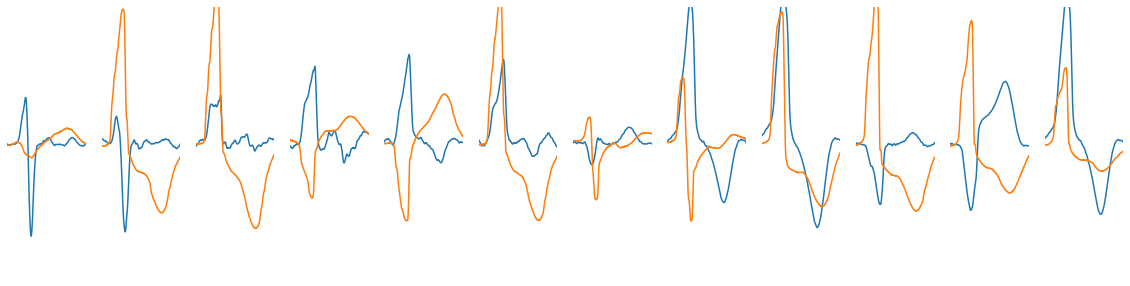

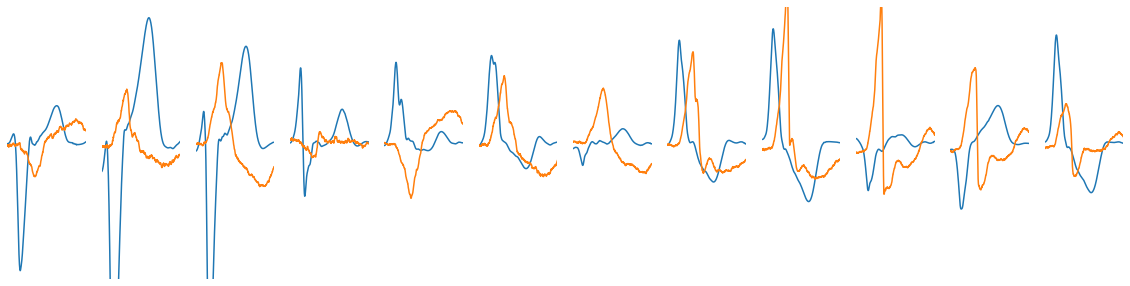

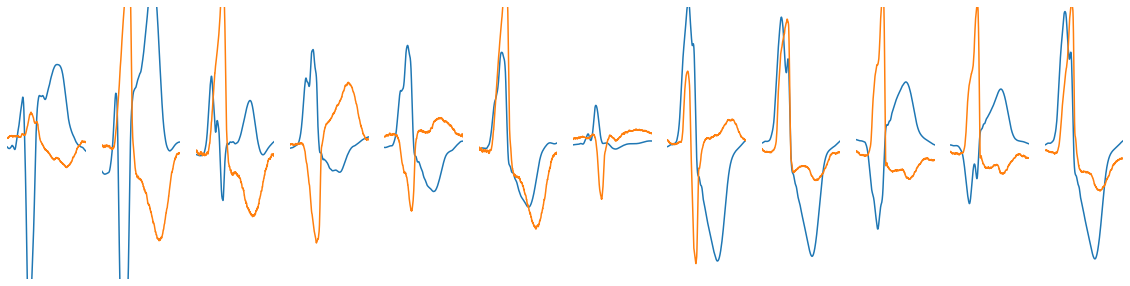

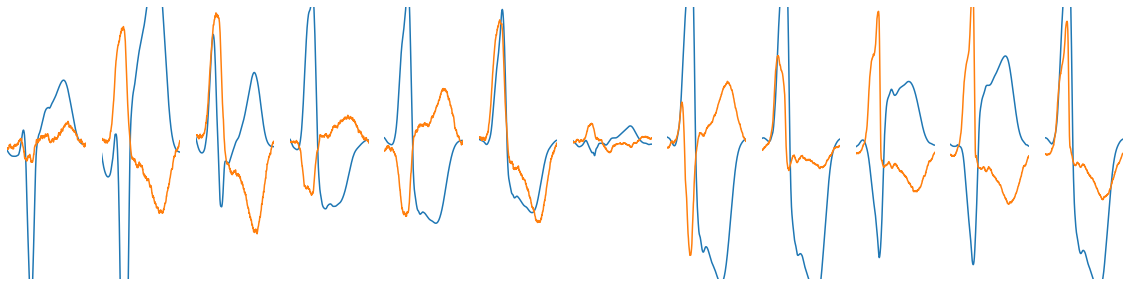

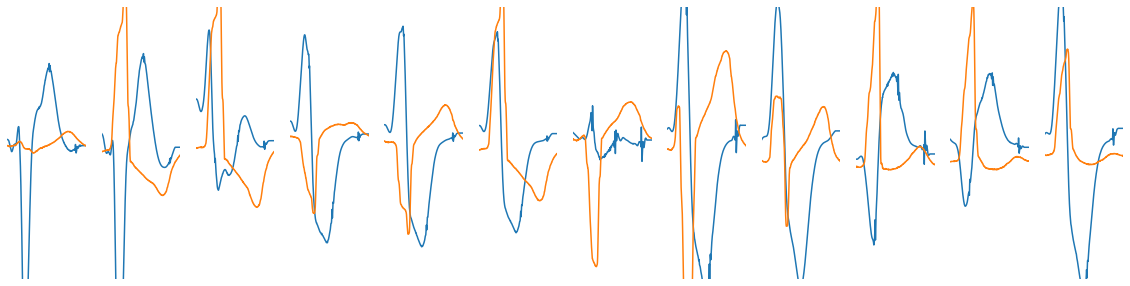

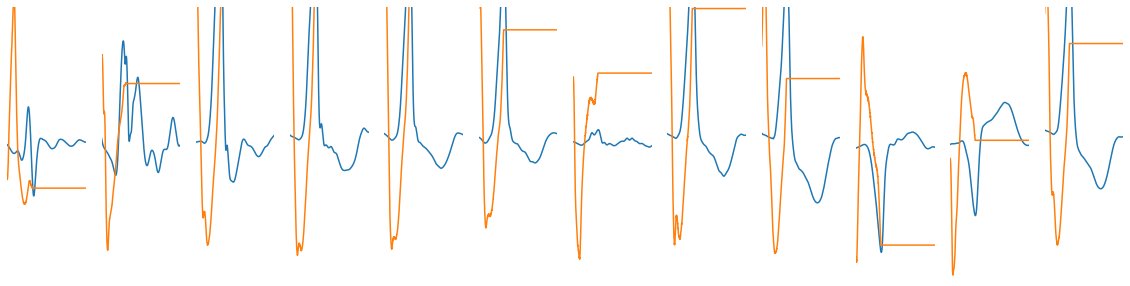

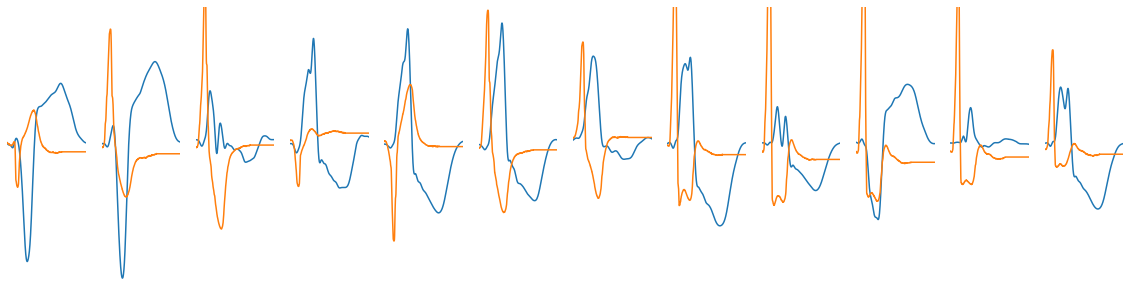

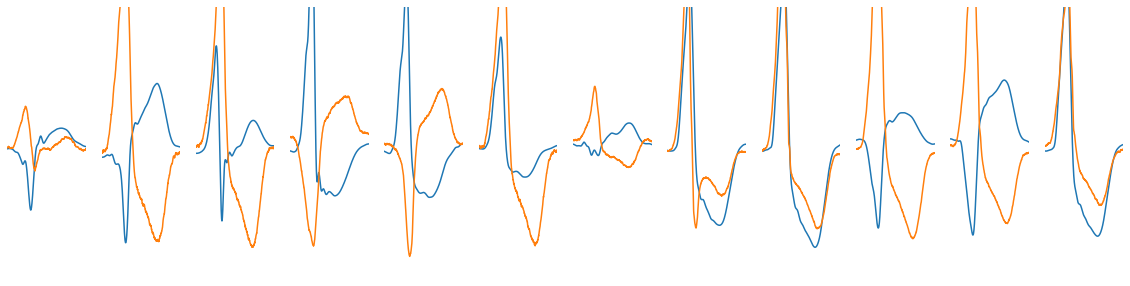

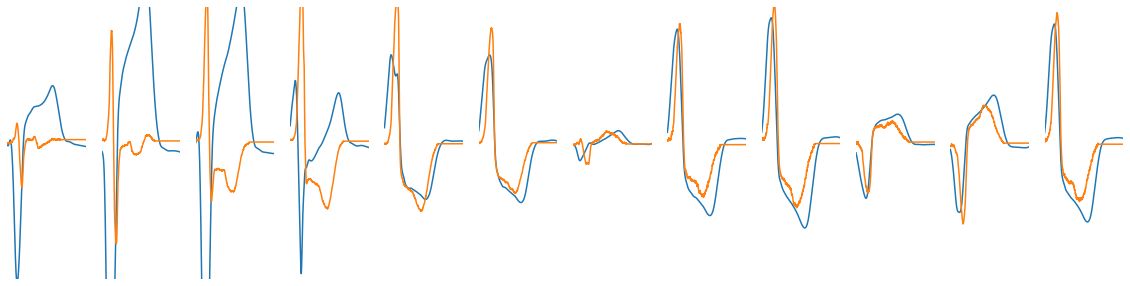

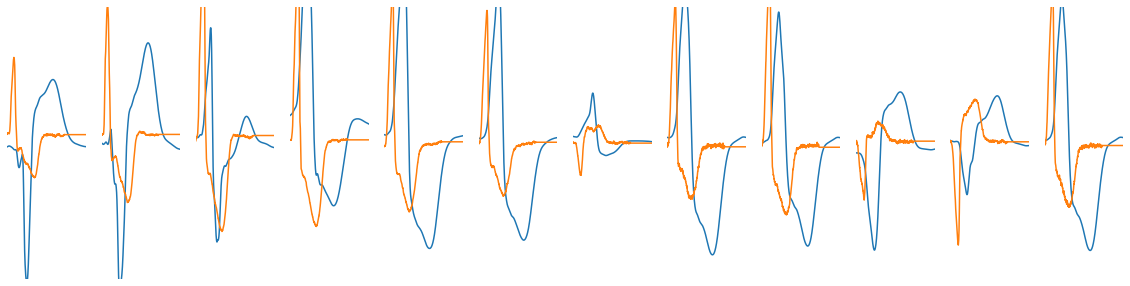

In [413]:
for i in range(10):
    torch_ecg_ZJ, label, str_location, file_name = train_data_loader[i]
    torch_ecg_TPE, label, str_location, file_name = train_data_loader_TPE[i]
    ecg_ZJ = torch_ecg_ZJ[0,:,:]
    ecg_TPE = torch_ecg_TPE[0,:,:]
    plt.figure(figsize=(20,5))
    for i in range(12):
        plt.subplot(1,12,i+1)
        plt.plot(ecg_ZJ[i,:])
        plt.plot(2*ecg_TPE[i,:])
        plt.xlim([0,1000])
        plt.ylim([-20000,20000])
        plt.axis('off')
    plt.show()


### CNN model for left and right

In [6]:
#set up model
import torch.nn as nn
import torch.nn.functional as F
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        #=========== Horizontal CNN===========
        # first CNN
        # H0 output 12x1024
        self.cnn_H0 = nn.Conv2d(in_channels=1, out_channels = 16, kernel_size=(1,129), stride=1, padding=(0,64)) #output_shape=(16,12,1024) 
        self.dropout_H0 = nn.Dropout(0.1)
        self.act_H0 = nn.ReLU() # activation
        
        # H1_1 output 16x12x1024
        self.cnn_H1_1 = nn.Conv2d(in_channels=16, out_channels = 16, kernel_size=(1,129), stride=1, padding=(0,64)) #output_shape=(16,12,1024) 
        self.dropout_H1_1 = nn.Dropout(0.1)
        self.act_H1_1 = nn.ReLU() # activation
       
        # bach norm
        self.bactN_H1 = nn.BatchNorm2d(16)
        # pool
        self.pool_H1 = nn.AvgPool2d(kernel_size=(1,2)) #16x12x1024 --> 16x12x512
        
        # H2_1 output 32x12x512
        self.cnn_H2_1 = nn.Conv2d(in_channels=16, out_channels = 32, kernel_size=(1,65), stride=1, padding=(0,32)) #output_shape=(16,12,1024) 
        self.dropout_H2_1 = nn.Dropout(0.1)
        self.act_H2_1 = nn.ReLU() # activation
      
        # bach norm
        self.bactN_H2 = nn.BatchNorm2d(32)
        #  pool 
        self.pool_H2 = nn.AvgPool2d(kernel_size=(1,2))  #32x12x512 --> 32x12x256
        
        # H3_1 output 64x12x256
        self.cnn_H3_1 = nn.Conv2d(in_channels=32, out_channels = 64, kernel_size=(1,33), stride=1, padding=(0,16)) #output_shape=(16,12,1024) 
        self.dropout_H3_1 = nn.Dropout(0.1)
        self.act_H3_1 = nn.ReLU() # activation
        
        
        # bach norm
        self.bactN_H3 = nn.BatchNorm2d(64)
        #  pool 
        self.pool_H3 = nn.AvgPool2d(kernel_size=(1,2)) #64x12x256 --> 64x12x128
        
        #=========== Vertical CNN===========
        
        # V0 output 64x1x128
        self.cnn_V0 = nn.Conv2d(in_channels=64, out_channels = 128, kernel_size=(12,1), stride=1, padding=(0,0)) #output_shape=(16,12,1024) 
        self.dropout_V0 = nn.Dropout(0.1)
        self.act_V0 = nn.ReLU() # activation
        
        # V1 
        self.cnn_V1_1 = nn.Conv2d(in_channels=128, out_channels = 128, kernel_size=(1,3), stride=1, padding=(0,1)) #output_shape=(16,12,1024) 
        self.dropout_V1_1 = nn.Dropout(0.1)
        self.act_V1_1 = nn.ReLU() # activation
        
        # bach norm
        self.bactN_V1 = nn.BatchNorm2d(128)
        #  pool 
        self.pool_V1 = nn.AvgPool2d(kernel_size=(1,2)) 
        
        #===========Fully connected layer========
        # Fully connected 1 
        self.fc1 = nn.Linear(128*1*64,1024)
        self.dropout_fc1 = nn.Dropout(0.1)
        self.actFC1 = nn.ReLU()# activation
        # Fully connected 2 with relu
        self.fc2 = nn.Linear(1024,1024)
        self.dropout_fc2 = nn.Dropout(0.1)
        self.actFC2 = nn.ReLU()# activation
        # Fully connected 3 with relu
        self.fc3 = nn.Linear(1024,1)
        self.output = nn.Sigmoid()
    
        #weight initialization
        self.initialize_weights()
        
    def forward(self, x):
        #horizontal cnn
        out = self.cnn_H0(x) 
        out = self.dropout_H0(out) 
        out = self.act_H0(out)
        
        out = self.cnn_H1_1(out)
        out = self.dropout_H1_1(out)
        out = self.act_H1_1(out)
        
        out = self.pool_H1(out)
        out = self.bactN_H1(out)
        
        out = self.cnn_H2_1(out)
        out = self.dropout_H2_1(out) 
        out = self.act_H2_1(out)
        
        out = self.bactN_H2(out)
        out = self.pool_H2(out)
        
        out = self.cnn_H3_1(out)
        out = self.dropout_H3_1(out) 
        out = self.act_H3_1(out)
        
        out = self.bactN_H3(out)
        out = self.pool_H3(out)
        
        out = self.cnn_V0(out)
        out = self.dropout_V0(out) 
        out = self.act_V0(out)
        
        out = self.cnn_V1_1(out) 
        out = self.dropout_V1_1(out)
        out = self.act_V1_1(out)
        
        out = self.bactN_V1(out)
        out = self.pool_V1(out)
        #print(np.shape(out))
        out = torch.flatten(out,1)
        
        out = self.fc1(out)   #fully connected 1
        out = self.dropout_fc1(out)
        out = self.actFC1(out)
        out = self.fc2(out)   #fully connected 2
        out = self.dropout_fc2(out)
        out = self.actFC2(out)
        out = self.fc3(out)   #fully connected 3
        out = self.output(out)
        return out
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight,nonlinearity='relu')
                print(m)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.kaiming_uniform_(m.weight,nonlinearity='relu')
                print(m)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias,0)

model = CNN_Model()
from torchsummary import summary
summary(model.cuda(), (1, 12, 1024))

Conv2d(1, 16, kernel_size=(1, 129), stride=(1, 1), padding=(0, 64))
Conv2d(16, 16, kernel_size=(1, 129), stride=(1, 1), padding=(0, 64))
Conv2d(16, 32, kernel_size=(1, 65), stride=(1, 1), padding=(0, 32))
Conv2d(32, 64, kernel_size=(1, 33), stride=(1, 1), padding=(0, 16))
Conv2d(64, 128, kernel_size=(12, 1), stride=(1, 1))
Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
Linear(in_features=8192, out_features=1024, bias=True)
Linear(in_features=1024, out_features=1024, bias=True)
Linear(in_features=1024, out_features=1, bias=True)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 12, 1024]           2,080
           Dropout-2         [-1, 16, 12, 1024]               0
              ReLU-3         [-1, 16, 12, 1024]               0
            Conv2d-4         [-1, 16, 12, 1024]          33,040
           Dropout-5         [-1, 16, 12, 1024]             

In [454]:
#https://discuss.pytorch.org/t/how-to-replace-all-relu-activations-in-a-pretrained-network/31591
#shift relu to LeakyReLU
for i, (name, layer) in enumerate(model.named_modules()):
    if isinstance(layer, nn.ReLU):
        setattr(model, name, nn.ELU())
        print(name)

act_H0
act_H1
act_H2_1
act_H3_1
act_V0
act_V1_1
actFC1
actFC2


In [455]:
from torchsummary import summary
summary(model.cuda(), (1, 12, 1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 12, 1024]           2,080
           Dropout-2         [-1, 16, 12, 1024]               0
               ELU-3         [-1, 16, 12, 1024]               0
            Conv2d-4         [-1, 16, 12, 1024]          33,040
       BatchNorm2d-5         [-1, 16, 12, 1024]              32
           Dropout-6         [-1, 16, 12, 1024]               0
         AvgPool2d-7          [-1, 16, 12, 512]               0
            Conv2d-8          [-1, 32, 12, 512]          33,312
           Dropout-9          [-1, 32, 12, 512]               0
              ELU-10          [-1, 32, 12, 512]               0
      BatchNorm2d-11          [-1, 32, 12, 512]              64
        AvgPool2d-12          [-1, 32, 12, 256]               0
           Conv2d-13          [-1, 64, 12, 256]          67,648
          Dropout-14          [-1, 64, 

# Load existing model

In [273]:
model.load_state_dict(torch.load('E:\\back up2\\Google Drive\\Large Files\\Datasets\\VT_datasets\\models\\model_CNN_LR_v5.pth'))
model.eval()

CNN_Model(
  (cnn_H0): Conv2d(1, 16, kernel_size=(1, 129), stride=(1, 1), padding=(0, 64))
  (dropout_H0): Dropout(p=0.0, inplace=False)
  (act_H0): ReLU()
  (cnn_H1_1): Conv2d(16, 16, kernel_size=(1, 129), stride=(1, 1), padding=(0, 64))
  (dropout_H1_1): Dropout(p=0.0, inplace=False)
  (act_H1_1): ReLU()
  (bactN_H1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_H1): AvgPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
  (cnn_H2_1): Conv2d(16, 32, kernel_size=(1, 65), stride=(1, 1), padding=(0, 32))
  (dropout_H2_1): Dropout(p=0.0, inplace=False)
  (act_H2_1): ReLU()
  (bactN_H2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_H2): AvgPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
  (cnn_H3_1): Conv2d(32, 64, kernel_size=(1, 33), stride=(1, 1), padding=(0, 16))
  (dropout_H3_1): Dropout(p=0.0, inplace=False)
  (act_H3_1): ReLU()
  (bactN_H3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

# Train model
<hr>

# Build model
<hr>
links for CNN 2D prediction
general tutorial
* https://hackmd.io/@lido2370/S1aX6e1nN?type=view
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* https://www.kaggle.com/basu369victor/pytorch-tutorial-the-classification
* https://www.pluralsight.com/guides/image-classification-with-pytorch
initialization
* https://www.youtube.com/watch?v=xWQ-p_o0Uik
* https://pytorch.org/docs/stable/nn.init.html

### Function to screen out VPC, VT or Sinus file list for further data loading

In [226]:
#function to rule out file only had VT, but no VPC
def get_file_VPC(path_folder):
    list_file_name = os.listdir(path_folder)
    list_target_file = []
    for i in range(len(list_file_name)):
        file_name = list_file_name[i] 
        wave_type = file_name.split('_')[0]
        if wave_type == 'VPC' :
            list_target_file.append(file_name)
        else:
            print(file_name)
    return list_target_file


#function to screen out wave base on label 
def get_file_Location(path_folder,list_file_name,dic_label):
    list_ID = []
    for i in range(len(list_file_name)):
        file_name = list_file_name[i]
        one_patient_dataframe = pd.read_csv(path_folder+'\\'+file_name,index_col=False)
        str_location = one_patient_dataframe['location'].iloc[-1] 
        ID = one_patient_dataframe['ID'].iloc[-1]
        #produce lable
        label = dic_label[str_location]
        #if the wave contain target label and the name had not been registered
        if ((label == 0) | (label == 1)) and (ID not in list_ID) :
            print(ID,label)
            list_ID.append(ID)
    return list_ID


import random

#function to randomly split file base on ID
def random_file_split(train_ratio, list_ID):
    random.shuffle(list_ID)
    len_file = len(list_ID)
    len_train = int(len_file*train_ratio)
    len_validation = len_file-len_train
    list_train = list_ID[ 0 : len_train ]
    list_validation = list_ID[ len_train : len_file ]
    return list_train,list_validation

#function to gather waves containing target ID
def gather_waves(list_ID, source_list, path_folder):
    full_file_name_list = []
    for i in range(len(source_list)):
        file_name = source_list[i]
        one_patient_dataframe = pd.read_csv(path_folder+'\\'+file_name,index_col=False)
        ID = one_patient_dataframe['ID'].iloc[-1]
        if ID in list_ID:
            print(file_name)
            full_file_name_list.append(file_name)
    return full_file_name_list

#weighted sample base on different location
def weighted_sampling(list_source,path_folder , df_weight):
    list_pool = [] #list of pool for sampling
    for i in range(len(list_source)):
        file_name = list_source[i]
        one_patient_dataframe = pd.read_csv(path_folder+'\\'+file_name,index_col=False)
        str_location = one_patient_dataframe['location'].iloc[-1]
        weight = df_weight[str_location]
        for k in range(weight):
            list_pool.append(file_name)
    random.shuffle(list_pool)
    return list_pool

In [252]:
df_weight = {
      #TPE part
      'LVOT_Supravalvular_LCC':3,
      'LVOT_Supravalvular_RCC':3,
      'LVOT_Supravalvular_NCC':0,
      'LVOT_Supravalvular_LCC/RCCjunction':3,
      'LVOT_Infravalvular_AMC':1,
      'LVOT_Supravalvular_Septo-parahisian':1,
      'LVOT_Epicardial_AIV/CGV':2,
      'LV_MA':1,
      'LV_PPM_Anterolateral':1,
      'LV_PPM_Posteromedial':1,
      'LV_Crux':1,
      'LV_FascicularVT_Left_posterior_fascicle':1,
      'LV_FascicularVT_Left_anterior_fascicle':1,
      'LV_FascicularVT_Left_upper_septal_fascicle':1,
      'RVOT':1,
      'RV_Parahisian':1,
      'RV_TA':1,
      'RV_PA':1,
      'RV_PPM':1,
      #ZJ part
      'LCC':2,
      'AMC':1,
      'RCC':2,
      'LCC-RCC Ommisure':2,
      'Summit':3,
      'LC':1,
      'RVOTOther':1,
      'PosteriorSeptal':1,
      'AC':1,
      'FreeWall':1,
      'AnteriorSeptal':1,
      'RC':1
}

In [241]:
path_folder = 'E:\\back up2\\Google Drive\\Large Files\\Datasets\\VT_datasets\\VPC2\\train'
list_with_VPC = get_file_VPC(path_folder)
list_ID = get_file_Location(path_folder , list_with_VPC , dic_LR)

Sinus_AC_1000364_0.csv
Sinus_AC_1000364_1.csv
Sinus_AC_1014570_0.csv
Sinus_AC_1014570_1.csv
Sinus_AC_1014570_2.csv
Sinus_AC_1014570_3.csv
Sinus_AC_1014570_4.csv
Sinus_AC_1014570_5.csv
Sinus_AC_1014570_6.csv
Sinus_AC_1014570_7.csv
Sinus_AC_1024809_0.csv
Sinus_AC_1024809_1.csv
Sinus_AC_1024809_2.csv
Sinus_AC_1024809_3.csv
Sinus_AC_1024809_4.csv
Sinus_AC_1024809_5.csv
Sinus_AC_1025769_0.csv
Sinus_AC_1025769_1.csv
Sinus_AC_1025769_2.csv
Sinus_AC_1025769_3.csv
Sinus_AC_1064513_0.csv
Sinus_AC_1064513_1.csv
Sinus_AC_1064513_2.csv
Sinus_AC_1064513_3.csv
Sinus_AC_1064513_4.csv
Sinus_AC_1064513_5.csv
Sinus_AC_1067472_0.csv
Sinus_AC_1067472_1.csv
Sinus_AC_1067472_2.csv
Sinus_AC_1067472_3.csv
Sinus_AC_1067551_0.csv
Sinus_AC_1067551_1.csv
Sinus_AC_1067551_2.csv
Sinus_AC_1067551_3.csv
Sinus_AC_1067684_0.csv
Sinus_AC_1067684_1.csv
Sinus_AC_1067684_2.csv
Sinus_AC_1067684_3.csv
Sinus_AC_1076905_0.csv
Sinus_AC_1076905_1.csv
Sinus_AC_1076905_2.csv
Sinus_AC_864337_0.csv
Sinus_AC_864337_1.csv
Sinus_AC_8643

Sinus_RV_PA_43913924_6.csv
Sinus_RV_PA_43913924_7.csv
Sinus_RV_PA_43913924_8.csv
Sinus_RV_PA_44137511_0.csv
Sinus_RV_PA_44137511_1.csv
Sinus_RV_PA_44137511_2.csv
Sinus_RV_PA_44137511_3.csv
Sinus_RV_PA_44137511_4.csv
Sinus_RV_PA_44137511_5.csv
Sinus_RV_PA_44137511_6.csv
Sinus_RV_PA_44137511_7.csv
Sinus_RV_PA_44686422_0.csv
Sinus_RV_PA_44686422_1.csv
Sinus_RV_PA_44686422_2.csv
Sinus_RV_PA_44686422_3.csv
Sinus_RV_PA_44686422_4.csv
Sinus_RV_PA_44686422_5.csv
Sinus_RV_PA_44957600_0.csv
Sinus_RV_PA_44957600_1.csv
Sinus_RV_PA_44988729_0.csv
Sinus_RV_PA_44988729_1.csv
Sinus_RV_PA_44988729_2.csv
Sinus_RV_PA_44988729_3.csv
Sinus_RV_PA_44988729_4.csv
Sinus_RV_PA_44988729_5.csv
Sinus_RV_PA_44988729_6.csv
Sinus_RV_PA_45868802_0.csv
Sinus_RV_PA_45868802_1.csv
Sinus_RV_PA_45868802_10.csv
Sinus_RV_PA_45868802_11.csv
Sinus_RV_PA_45868802_12.csv
Sinus_RV_PA_45868802_13.csv
Sinus_RV_PA_45868802_14.csv
Sinus_RV_PA_45868802_2.csv
Sinus_RV_PA_45868802_3.csv
Sinus_RV_PA_45868802_4.csv
Sinus_RV_PA_45868802_5.

1067551 1
1067684 1
1076905 1
864337 1
868445 1
872987 1
875558 1
875993 1
881401 1
882311 1
907714 1
907716 1
909086 1
915010 1
922658 1
944160 1
944739 1
946273 1
962668 1
970087 1
980242 1
986604 1
998419 1
1029683 0
1035943 0
781873 0
809442 0
810553 0
833965 0
866996 0
875515 0
880464 0
887779 0
899270 0
901632 0
916739 0
920969 0
939853 0
951633 0
960365 0
990309 0
1003838 1
742264 1
743463 1
744169 1
757870 1
767643 1
777318 1
778240 1
790920 1
792062 1
805885 1
809339 1
813999 1
833657 1
835287 1
842383 1
851601 1
852061 1
855066 1
858661 1
861217 1
861583 1
888019 1
893994 1
910370 1
940412 1
954933 1
954965 1
707971 1
745648 1
763536 1
766507 1
766688 1
778725 1
779381 1
779858 1
779926 1
791296 1
810867 1
826564 1
834075 1
837656 1
839738 1
846157 1
846909 1
855203 1
862892 1
905245 1
926419 1
931371 1
931393 1
932457 1
936021 1
938165 1
952036 1
786873 0
805788 0
822228 0
856319 0
866682 0
891363 0
902441 0
1011746 0
1016466 0
1033064 0
762912 0
763863 0
765410 0
767156 0
7

In [253]:
path_folder = 'E:\\back up2\\Google Drive\\Large Files\\Datasets\\VT_datasets\\VPC2\\train'
train_ID,validation_ID = random_file_split(0.9,list_ID)
list_train = gather_waves(train_ID , list_with_VPC , path_folder)
list_train = weighted_sampling(list_train , path_folder, df_weight)
list_validation = gather_waves(validation_ID , list_with_VPC , path_folder)
print(len(list_train),len(list_validation))

VPC_AC_1014570_10.csv
VPC_AC_1014570_8.csv
VPC_AC_1014570_9.csv
VPC_AC_1024809_13.csv
VPC_AC_1024809_6.csv
VPC_AC_1024809_7.csv
VPC_AC_1024809_8.csv
VPC_AC_1064513_10.csv
VPC_AC_1064513_6.csv
VPC_AC_1064513_7.csv
VPC_AC_1064513_8.csv
VPC_AC_1064513_9.csv
VPC_AC_1067472_4.csv
VPC_AC_1067472_5.csv
VPC_AC_1067472_6.csv
VPC_AC_1067551_4.csv
VPC_AC_1067551_5.csv
VPC_AC_1067551_6.csv
VPC_AC_1067551_7.csv
VPC_AC_1067551_8.csv
VPC_AC_1076905_3.csv
VPC_AC_1076905_4.csv
VPC_AC_1076905_5.csv
VPC_AC_1076905_6.csv
VPC_AC_864337_6.csv
VPC_AC_864337_7.csv
VPC_AC_864337_8.csv
VPC_AC_864337_9.csv
VPC_AC_868445_4.csv
VPC_AC_868445_5.csv
VPC_AC_875558_5.csv
VPC_AC_875558_6.csv
VPC_AC_875558_9.csv
VPC_AC_875993_5.csv
VPC_AC_875993_6.csv
VPC_AC_875993_7.csv
VPC_AC_875993_8.csv
VPC_AC_881401_4.csv
VPC_AC_881401_5.csv
VPC_AC_882311_3.csv
VPC_AC_882311_4.csv
VPC_AC_882311_5.csv
VPC_AC_907714_6.csv
VPC_AC_907714_7.csv
VPC_AC_907716_4.csv
VPC_AC_915010_10.csv
VPC_AC_915010_11.csv
VPC_AC_915010_7.csv
VPC_AC_9150

VPC_FreeWall_846157_8.csv
VPC_FreeWall_846157_9.csv
VPC_FreeWall_846909_10.csv
VPC_FreeWall_846909_11.csv
VPC_FreeWall_846909_12.csv
VPC_FreeWall_846909_5.csv
VPC_FreeWall_846909_6.csv
VPC_FreeWall_846909_7.csv
VPC_FreeWall_846909_8.csv
VPC_FreeWall_846909_9.csv
VPC_FreeWall_855203_2.csv
VPC_FreeWall_905245_4.csv
VPC_FreeWall_905245_5.csv
VPC_FreeWall_905245_6.csv
VPC_FreeWall_905245_7.csv
VPC_FreeWall_905245_8.csv
VPC_FreeWall_926419_4.csv
VPC_FreeWall_926419_5.csv
VPC_FreeWall_926419_6.csv
VPC_FreeWall_926419_7.csv
VPC_FreeWall_931371_6.csv
VPC_FreeWall_931371_7.csv
VPC_FreeWall_931371_8.csv
VPC_FreeWall_932457_7.csv
VPC_FreeWall_936021_7.csv
VPC_FreeWall_936021_8.csv
VPC_FreeWall_936021_9.csv
VPC_FreeWall_938165_7.csv
VPC_FreeWall_938165_8.csv
VPC_FreeWall_952036_10.csv
VPC_FreeWall_952036_11.csv
VPC_FreeWall_952036_8.csv
VPC_FreeWall_952036_9.csv
VPC_LCC-RCC Ommisure_786873_4.csv
VPC_LCC-RCC Ommisure_786873_5.csv
VPC_LCC-RCC Ommisure_786873_6.csv
VPC_LCC-RCC Ommisure_786873_7.csv
V

VPC_LC_935074_9.csv
VPC_LC_936628_5.csv
VPC_LC_936628_6.csv
VPC_LC_936628_7.csv
VPC_LC_948109_4.csv
VPC_LC_948109_5.csv
VPC_LC_954735_10.csv
VPC_LC_954735_11.csv
VPC_LC_954735_6.csv
VPC_LC_954735_7.csv
VPC_LC_954735_8.csv
VPC_LC_954735_9.csv
VPC_LC_967769_5.csv
VPC_LC_967769_6.csv
VPC_LC_967769_7.csv
VPC_LC_967769_8.csv
VPC_LC_970213_10.csv
VPC_LC_970213_8.csv
VPC_LC_970213_9.csv
VPC_LC_976147_10.csv
VPC_LC_976147_6.csv
VPC_LC_976147_7.csv
VPC_LC_976147_8.csv
VPC_LC_976147_9.csv
VPC_LC_976401_10.csv
VPC_LC_976401_6.csv
VPC_LC_976401_7.csv
VPC_LC_976401_8.csv
VPC_LC_976401_9.csv
VPC_LC_976913_10.csv
VPC_LC_976913_5.csv
VPC_LC_976913_6.csv
VPC_LC_976913_7.csv
VPC_LC_976913_8.csv
VPC_LC_976913_9.csv
VPC_LC_978916_5.csv
VPC_LC_978916_6.csv
VPC_LC_981890_3.csv
VPC_LC_981890_4.csv
VPC_LC_981890_5.csv
VPC_LC_981890_6.csv
VPC_LC_981890_7.csv
VPC_LC_981890_8.csv
VPC_LC_981890_9.csv
VPC_LC_988362_5.csv
VPC_LC_988362_6.csv
VPC_LC_988362_7.csv
VPC_LC_988362_8.csv
VPC_LC_988990_10.csv
VPC_LC_988990

VPC_LVOT_Epicardial_AIVCGV_4143218-2_11.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_12.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_13.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_14.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_15.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_16.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_17.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_18.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_19.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_20.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_21.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_22.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_23.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_24.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_25.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_26.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_27.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_5.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_6.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_7.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_8.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_9.csv
VPC_LVOT_Epicardial_AIVCGV_42403770_1

VPC_LVOT_Epicardial_AIVCGV_44326821_2.csv
VPC_LVOT_Epicardial_AIVCGV_44394390A_1.csv
VPC_LVOT_Epicardial_AIVCGV_45072466_10.csv
VPC_LVOT_Epicardial_AIVCGV_45072466_11.csv
VPC_LVOT_Epicardial_AIVCGV_45072466_6.csv
VPC_LVOT_Epicardial_AIVCGV_45072466_7.csv
VPC_LVOT_Epicardial_AIVCGV_45072466_8.csv
VPC_LVOT_Epicardial_AIVCGV_45072466_9.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_10.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_11.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_12.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_13.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_14.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_15.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_16.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_17.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_18.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_19.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_6.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_7.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_8.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_9.csv
VPC_LVOT_Epicardial_AIVCGV_45287545_4.csv
VPC_LVOT_Epicardial_A

VPC_LVOT_Supravalvular_LCCRCCjunction_36964973_17.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_36964973_18.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_36964973_19.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_36964973_20.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_36964973_21.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_36964973_22.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_36964973_23.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_36964973_24.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_36964973_25.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_36964973_26.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_41405043_10.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_41405043_11.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_42885927_10.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_42885927_11.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_42885927_12.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_42885927_13.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_42885927_14.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_42885927_15.csv
VPC_LVOT_Supravalvular_LCCRC

VPC_LVOT_Supravalvular_LCC_44258799_13.csv
VPC_LVOT_Supravalvular_LCC_44258799_14.csv
VPC_LVOT_Supravalvular_LCC_44258799_15.csv
VPC_LVOT_Supravalvular_LCC_44258799_16.csv
VPC_LVOT_Supravalvular_LCC_44258799_17.csv
VPC_LVOT_Supravalvular_LCC_44258799_18.csv
VPC_LVOT_Supravalvular_LCC_44258799_19.csv
VPC_LVOT_Supravalvular_LCC_44258799_20.csv
VPC_LVOT_Supravalvular_LCC_44258799_21.csv
VPC_LVOT_Supravalvular_LCC_44258799_22.csv
VPC_LVOT_Supravalvular_LCC_44258799_23.csv
VPC_LVOT_Supravalvular_LCC_44258799_7.csv
VPC_LVOT_Supravalvular_LCC_44258799_8.csv
VPC_LVOT_Supravalvular_LCC_44258799_9.csv
VPC_LVOT_Supravalvular_LCC_44435532_10.csv
VPC_LVOT_Supravalvular_LCC_44435532_11.csv
VPC_LVOT_Supravalvular_LCC_44435532_12.csv
VPC_LVOT_Supravalvular_LCC_44435532_13.csv
VPC_LVOT_Supravalvular_LCC_44435532_14.csv
VPC_LVOT_Supravalvular_LCC_44435532_7.csv
VPC_LVOT_Supravalvular_LCC_44435532_8.csv
VPC_LVOT_Supravalvular_LCC_44435532_9.csv
VPC_LVOT_Supravalvular_LCC_44525340_5.csv
VPC_LVOT_Supravalv

VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_11.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_12.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_13.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_14.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_15.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_16.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_17.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_18.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_19.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_20.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_21.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_22.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_23.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_24.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_25.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_26.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_27.c

VPC_LV_PPM_Anterolateral_4597141-3_15.csv
VPC_LV_PPM_Anterolateral_4597141-3_16.csv
VPC_LV_PPM_Anterolateral_4597141-3_17.csv
VPC_LV_PPM_Anterolateral_4597141-3_9.csv
VPC_LV_PPM_Posteromedial_41498991_0.csv
VPC_LV_PPM_Posteromedial_41498991_1.csv
VPC_LV_PPM_Posteromedial_41498991_2.csv
VPC_LV_PPM_Posteromedial_41498991_3.csv
VPC_LV_PPM_Posteromedial_41498991_4.csv
VPC_LV_PPM_Posteromedial_41498991_5.csv
VPC_LV_PPM_Posteromedial_41498991_6.csv
VPC_LV_PPM_Posteromedial_41498991_7.csv
VPC_LV_PPM_Posteromedial_41498991_8.csv
VPC_LV_PPM_Posteromedial_41498991_9.csv
VPC_PosteriorSeptal_1003549_10.csv
VPC_PosteriorSeptal_1003549_11.csv
VPC_PosteriorSeptal_1003549_7.csv
VPC_PosteriorSeptal_1003549_8.csv
VPC_PosteriorSeptal_1003549_9.csv
VPC_PosteriorSeptal_1064886_10.csv
VPC_PosteriorSeptal_1064886_11.csv
VPC_PosteriorSeptal_1064886_7.csv
VPC_PosteriorSeptal_1064886_8.csv
VPC_PosteriorSeptal_1064886_9.csv
VPC_PosteriorSeptal_702840_4.csv
VPC_PosteriorSeptal_702840_5.csv
VPC_PosteriorSeptal_702

VPC_RVOT_28273394_13.csv
VPC_RVOT_28273394_14.csv
VPC_RVOT_28273394_15.csv
VPC_RVOT_28273394_16.csv
VPC_RVOT_28273394_17.csv
VPC_RVOT_28273394_18.csv
VPC_RVOT_28273394_9.csv
VPC_RVOT_2843238-4_10.csv
VPC_RVOT_2843238-4_11.csv
VPC_RVOT_2843238-4_12.csv
VPC_RVOT_2843238-4_13.csv
VPC_RVOT_2843238-4_14.csv
VPC_RVOT_2843238-4_15.csv
VPC_RVOT_2843238-4_16.csv
VPC_RVOT_2843238-4_17.csv
VPC_RVOT_2843238-4_18.csv
VPC_RVOT_28684971_2.csv
VPC_RVOT_28684971_4.csv
VPC_RVOT_29053687_15.csv
VPC_RVOT_29053687_16.csv
VPC_RVOT_29053687_17.csv
VPC_RVOT_29053687_18.csv
VPC_RVOT_29053687_19.csv
VPC_RVOT_29053687_20.csv
VPC_RVOT_29053687_21.csv
VPC_RVOT_29053687_22.csv
VPC_RVOT_29053687_23.csv
VPC_RVOT_29053687_24.csv
VPC_RVOT_29053687_25.csv
VPC_RVOT_29053687_26.csv
VPC_RVOT_29053687_27.csv
VPC_RVOT_29053687_28.csv
VPC_RVOT_30691986_2.csv
VPC_RVOT_30821875_10.csv
VPC_RVOT_30821875_11.csv
VPC_RVOT_30821875_12.csv
VPC_RVOT_30821875_13.csv
VPC_RVOT_30821875_14.csv
VPC_RVOT_30821875_6.csv
VPC_RVOT_30821875_7.c

VPC_RVOT_45597260_23.csv
VPC_RVOT_45597260_7.csv
VPC_RVOT_45597260_8.csv
VPC_RVOT_45597260_9.csv
VPC_RVOT_45607543_2.csv
VPC_RVOT_45692113_10.csv
VPC_RVOT_45692113_11.csv
VPC_RVOT_45692113_12.csv
VPC_RVOT_45692113_13.csv
VPC_RVOT_45692113_14.csv
VPC_RVOT_45692113_15.csv
VPC_RVOT_45692113_16.csv
VPC_RVOT_45692113_17.csv
VPC_RVOT_45692113_18.csv
VPC_RVOT_45692113_19.csv
VPC_RVOT_45692113_20.csv
VPC_RVOT_45692113_21.csv
VPC_RVOT_45692113_22.csv
VPC_RVOT_45692113_23.csv
VPC_RVOT_45692113_24.csv
VPC_RVOT_45692113_25.csv
VPC_RVOT_45692113_26.csv
VPC_RVOT_45692113_27.csv
VPC_RVOT_45692113_5.csv
VPC_RVOT_45692113_6.csv
VPC_RVOT_45692113_7.csv
VPC_RVOT_45692113_8.csv
VPC_RVOT_45692113_9.csv
VPC_RVOT_45694299_6.csv
VPC_RVOT_45694299_7.csv
VPC_RVOT_45694299_8.csv
VPC_RVOT_45694299_9.csv
VPC_RVOT_45787517_3.csv
VPC_RVOT_45787517_4.csv
VPC_RVOT_45787517_5.csv
VPC_RVOT_45787517_6.csv
VPC_RVOT_45787517_7.csv
VPC_RVOT_45863692_12.csv
VPC_RVOT_45863692_13.csv
VPC_RVOT_45863692_14.csv
VPC_RVOT_45863692_

VPC_RV_PA_42362710_5.csv
VPC_RV_PA_42362710_6.csv
VPC_RV_PA_42362710_7.csv
VPC_RV_PA_42362710_8.csv
VPC_RV_PA_42362710_9.csv
VPC_RV_PA_43589135_3.csv
VPC_RV_PA_43913924_10.csv
VPC_RV_PA_43913924_11.csv
VPC_RV_PA_43913924_9.csv
VPC_RV_PA_44137511_10.csv
VPC_RV_PA_44137511_11.csv
VPC_RV_PA_44137511_12.csv
VPC_RV_PA_44137511_8.csv
VPC_RV_PA_44137511_9.csv
VPC_RV_PA_44686422_10.csv
VPC_RV_PA_44686422_11.csv
VPC_RV_PA_44686422_12.csv
VPC_RV_PA_44686422_13.csv
VPC_RV_PA_44686422_14.csv
VPC_RV_PA_44686422_15.csv
VPC_RV_PA_44686422_16.csv
VPC_RV_PA_44686422_17.csv
VPC_RV_PA_44686422_6.csv
VPC_RV_PA_44686422_7.csv
VPC_RV_PA_44686422_8.csv
VPC_RV_PA_44686422_9.csv
VPC_RV_PA_44957600_2.csv
VPC_RV_PA_44988729_10.csv
VPC_RV_PA_44988729_11.csv
VPC_RV_PA_44988729_7.csv
VPC_RV_PA_44988729_8.csv
VPC_RV_PA_44988729_9.csv
VPC_RV_PA_45868802_15.csv
VPC_RV_PA_45868802_16.csv
VPC_RV_PA_45868802_17.csv
VPC_RV_PA_45868802_18.csv
VPC_RV_PA_45868802_19.csv
VPC_RV_PA_45868802_20.csv
VPC_RV_PA_45868802_21.csv
VPC

VPC_LC_1034448_6.csv
VPC_LC_1034448_7.csv
VPC_LC_982506_3.csv
VPC_LVOT_Epicardial_AIVCGV_16602861A_6.csv
VPC_LVOT_Epicardial_AIVCGV_16602861A_7.csv
VPC_LVOT_Epicardial_AIVCGV_16602861A_8.csv
VPC_LVOT_Epicardial_AIVCGV_2174207-4_10.csv
VPC_LVOT_Epicardial_AIVCGV_2174207-4_11.csv
VPC_LVOT_Epicardial_AIVCGV_2174207-4_12.csv
VPC_LVOT_Epicardial_AIVCGV_2174207-4_13.csv
VPC_LVOT_Epicardial_AIVCGV_2174207-4_14.csv
VPC_LVOT_Epicardial_AIVCGV_2174207-4_15.csv
VPC_LVOT_Epicardial_AIVCGV_2174207-4_4.csv
VPC_LVOT_Epicardial_AIVCGV_2174207-4_5.csv
VPC_LVOT_Epicardial_AIVCGV_2174207-4_6.csv
VPC_LVOT_Epicardial_AIVCGV_2174207-4_7.csv
VPC_LVOT_Epicardial_AIVCGV_2174207-4_8.csv
VPC_LVOT_Epicardial_AIVCGV_2174207-4_9.csv
VPC_LVOT_Epicardial_AIVCGV_26797535_10.csv
VPC_LVOT_Epicardial_AIVCGV_26797535_5.csv
VPC_LVOT_Epicardial_AIVCGV_26797535_6.csv
VPC_LVOT_Epicardial_AIVCGV_26797535_7.csv
VPC_LVOT_Epicardial_AIVCGV_26797535_8.csv
VPC_LVOT_Epicardial_AIVCGV_26797535_9.csv
VPC_LVOT_Epicardial_AIVCGV_2860120

VPC_RVOT_45976065_41.csv
VPC_RVOT_45976065_42.csv
VPC_RVOT_45976065_43.csv
VPC_RVOT_45976065_44.csv
VPC_RVOT_45976065_45.csv
VPC_RVOT_45976065_46.csv
VPC_RVOT_45976065_47.csv
VPC_RVOT_45976065_48.csv
VPC_RVOT_45976065_49.csv
VPC_RVOT_45976065_50.csv
VPC_RVOT_45976065_51.csv
VPC_RVOT_45976065_52.csv
VPC_RVOT_45976065_53.csv
VPC_RVOT_45976065_54.csv
VPC_RVOT_46412446_2.csv
VPC_RVOT_46571486_8.csv
VPC_RV_PA_25417690_16.csv
VPC_RV_PA_25417690_17.csv
VPC_RV_PA_42684866_10.csv
VPC_RV_PA_42684866_11.csv
VPC_RV_PA_42684866_12.csv
VPC_RV_PA_42684866_13.csv
VPC_RV_PA_42684866_14.csv
VPC_RV_PA_42684866_6.csv
VPC_RV_PA_42684866_7.csv
VPC_RV_PA_42684866_8.csv
VPC_RV_PA_42684866_9.csv
VPC_RV_TA_44921144_2.csv
VPC_Summit_964638_4.csv
VPC_Summit_964638_5.csv
VPC_Summit_964638_6.csv
VPC_Summit_964638_7.csv
4871 369


### Prepare data loader

In [255]:
data_transform = transforms.Compose([
#         Random_trimming(50),
        Random_strech([0.8,1.2]),
#         Random_drift(100),
#         Random_scale([1,1],[0.25,4]),
#         Random_vertical_drift_tilt(1000,1000),
#         Add_noise(10),
        Add_edge_tail(1024),
        To_torch_tensor()
    ])
data_transform_validation = transforms.Compose([
        Add_edge_tail(1024),
        To_torch_tensor()
    ])
train_data_loader = VPC_dataset( list_train,  path_folder , dic_LR, transform = data_transform )
validation_data_loader = VPC_dataset( list_validation , path_folder , dic_LR, transform = data_transform_validation)

### count class number

In [256]:
list_count=[0]*2
total = 0
for i in range(len(train_data_loader)):
    total+=1
    ecg, label, location, file_name = train_data_loader[i]
    list_count[label.item()]+=1
    
print(list_count,total)    

[3097, 1774] 4871


### Setup lost function

In [257]:
#no weighted sampling
train_loader = DataLoader(train_data_loader, batch_size = 64, num_workers=0,shuffle=True)
valid_loader = DataLoader(validation_data_loader, batch_size = 64, num_workers=0,shuffle=True)

In [43]:
#try weighted sampling
class_weights = []
for i in range(len(list_count)):
    class_weights.append(total/list_count[i])
print(class_weights)
sample_weights = [0]*len(train_data_loader) #initialize the weight list for assigning
for i in range(len(train_data_loader)):       #loop through all data and assign its sampling weight
    data, target, location, file_name=train_data_loader[i]
    
    sample_weights[i] = class_weights[int(target.item())] 
    
weightedsampler_train = WeightedRandomSampler(sample_weights, 4096, replacement=True)

train_loader = DataLoader(train_data_loader, batch_size = 64, num_workers=0,shuffle=False, sampler = weightedsampler_train)

sample_weights_valid = [0]*len(validation_data_loader) #initialize the weight list for assigning
for i in range(len(validation_data_loader)):       #loop through all data and assign its sampling weight
    data, target, location, file_name=validation_data_loader[i]
    sample_weights_valid[i] = class_weights[int(target.item())] 
weightedsampler_valid = WeightedRandomSampler(sample_weights_valid, 256, replacement=True)

valid_loader = DataLoader(validation_data_loader, batch_size = 64, num_workers=0,shuffle=False, sampler = weightedsampler_valid)

[2.1379738968303292, 1.8787547788093937]


In [264]:
import torch.optim as optim
criterion = torch.nn.BCELoss()
# import itertools
# conv_params = itertools.chain.from_iterable([m.parameters() for m in model.children()
#                                              if isinstance(m, nn.Conv2d)])
# other_params = itertools.chain.from_iterable([m.parameters() for m in model.children()
#                                               if not isinstance(m, nn.Conv2d)]) 
# optimizer = torch.optim.Adam([{'params': other_params},
#                              {'params': conv_params, 'lr': 0.0000000001}],  # set init lr to 0
#                             lr=0.000001)


#fix certain layer
#https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6
params = model.state_dict()
#print(params.keys())
model.cnn_H0.weight.requires_grad = False
model.cnn_H1_1.weight.requires_grad = False
model.cnn_H2_1.weight.requires_grad = False
model.cnn_H3_1.weight.requires_grad = False
model.cnn_V0.weight.requires_grad = False
model.cnn_V1_1.weight.requires_grad = False 
summary(model.cuda(), (1, 12, 1024))

optimizer = torch.optim.Adam(model.parameters(),lr=0.00001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 12, 1024]           2,080
           Dropout-2         [-1, 16, 12, 1024]               0
              ReLU-3         [-1, 16, 12, 1024]               0
            Conv2d-4         [-1, 16, 12, 1024]          33,040
           Dropout-5         [-1, 16, 12, 1024]               0
              ReLU-6         [-1, 16, 12, 1024]               0
         AvgPool2d-7          [-1, 16, 12, 512]               0
       BatchNorm2d-8          [-1, 16, 12, 512]              32
            Conv2d-9          [-1, 32, 12, 512]          33,312
          Dropout-10          [-1, 32, 12, 512]               0
             ReLU-11          [-1, 32, 12, 512]               0
      BatchNorm2d-12          [-1, 32, 12, 512]              64
        AvgPool2d-13          [-1, 32, 12, 256]               0
           Conv2d-14          [-1, 64, 

### Training loop

In [98]:
#set up lost function
import torch.optim as optim
#try class weihting, class count is 55,38,161,57, total 311
#weight = torch.tensor([311/55,311/38,311/161,311/57])
#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss()

# Learning rate scheduler
https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling

In [ ]:
# CNN, linear learning rate modification
import itertools
conv_params = itertools.chain.from_iterable([m.parameters() for m in model.children()
                                             if isinstance(m, nn.Conv2d)])
other_params = itertools.chain.from_iterable([m.parameters() for m in model.children()
                                              if not isinstance(m, nn.Conv2d)]) 
optimizer = torch.optim.Adam([{'params': other_params},
                             {'params': conv_params, 'lr': 0.00000001}],  # set init lr to 0
                            lr=0.00001)

In [182]:
#CyclicLR - triangular
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00001, max_lr=0.01,step_size_up=8,mode="triangular")

In [258]:
#CyclicLR - triangular, expotentially decreasing
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0000000001, max_lr=0.001,step_size_up=32,mode="triangular2")

In [28]:
#CosineAnnealingLR
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=8, eta_min=0)

In [48]:
#CyclicLR - exp_range
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00001, max_lr=0.01,step_size_up=8,mode="exp_range",gamma=0.98)

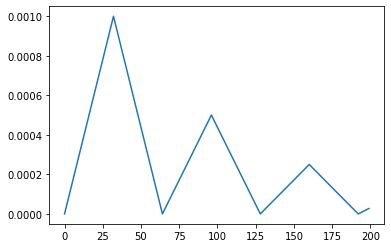

In [233]:
lrs = []
for i in range(200):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
#     print("Factor = ",i," , Learning Rate = ",optimizer.param_groups[0]["lr"])
    scheduler.step()
plt.plot(lrs)

In [185]:
#learning rate expoential decay
optimizer = torch.optim.Adam(model.parameters(),lr=0.00001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [43]:
valid_loss_min = np.Inf # track change in validation loss

In [31]:
model.initialize_weights()

Conv2d(1, 16, kernel_size=(1, 129), stride=(1, 1), padding=(0, 64))
Conv2d(16, 16, kernel_size=(1, 129), stride=(1, 1), padding=(0, 64))
Conv2d(16, 32, kernel_size=(1, 65), stride=(1, 1), padding=(0, 32))
Conv2d(32, 64, kernel_size=(1, 33), stride=(1, 1), padding=(0, 16))
Conv2d(64, 128, kernel_size=(12, 1), stride=(1, 1))
Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
Linear(in_features=8192, out_features=1024, bias=True)
Linear(in_features=1024, out_features=1024, bias=True)
Linear(in_features=1024, out_features=1, bias=True)


In [76]:
#adjust all dropout rate
drop_rate = 0.0
for m in model.modules():
            if isinstance(m,nn.Dropout):
                print(m.p)
                m.p = drop_rate

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


# weight reinitialization

In [53]:
#reinitialize weight
for m in model.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.xavier_uniform_(m.weight,gain=nn.init.calculate_gain('relu'))
                print(m)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.xavier_uniform_(m.weight,gain=nn.init.calculate_gain('relu'))
                print(m)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias,0)

Conv2d(1, 16, kernel_size=(1, 129), stride=(1, 1), padding=(0, 64))
Conv2d(16, 16, kernel_size=(1, 129), stride=(1, 1), padding=(0, 64))
Conv2d(16, 32, kernel_size=(1, 65), stride=(1, 1), padding=(0, 32))
Conv2d(32, 64, kernel_size=(1, 33), stride=(1, 1), padding=(0, 16))
Conv2d(64, 128, kernel_size=(12, 1), stride=(1, 1))
Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
Linear(in_features=8192, out_features=1024, bias=True)
Linear(in_features=1024, out_features=1024, bias=True)
Linear(in_features=1024, out_features=1, bias=True)


In [53]:
#reinitialize weight
for m in model.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.xavier_normal_(m.weight,gain=nn.init.calculate_gain('relu'))
                print(m)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.xavier_normal_(m.weight,gain=nn.init.calculate_gain('relu'))
                print(m)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias,0)

Conv2d(1, 16, kernel_size=(1, 129), stride=(1, 1), padding=(0, 64))
Conv2d(16, 16, kernel_size=(1, 129), stride=(1, 1), padding=(0, 64))
Conv2d(16, 32, kernel_size=(1, 65), stride=(1, 1), padding=(0, 32))
Conv2d(32, 64, kernel_size=(1, 33), stride=(1, 1), padding=(0, 16))
Conv2d(64, 128, kernel_size=(12, 1), stride=(1, 1))
Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
Linear(in_features=8192, out_features=1024, bias=True)
Linear(in_features=1024, out_features=1024, bias=True)
Linear(in_features=1024, out_features=1, bias=True)


In [265]:
# https://hackmd.io/@lido2370/S1aX6e1nN?type=view
from tqdm import tqdm_notebook as tqdm
train_on_gpu = torch.cuda.is_available()
accumulation_step = 8
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
if train_on_gpu:
    model.cuda()
# number of epochs to train the model
n_epochs = 16
#train_losses,valid_losses=[],[]

for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    print('running epoch: {}'.format(epoch))
    ###################
    # train the model #
    ###################
    model.train()
    idx = 0
    for data, target, location, file_name in tqdm(train_loader):
        idx += 1
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        output = output[:,0]
        # calculate the batch loss
        loss = criterion(output, target.float())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        if (idx % accumulation_step) == 0:
#             print('update')
            # perform a single optimization step (parameter update)
            optimizer.step()
            scheduler.step()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()     
        # update training loss
        train_loss += loss.item()*data.size(0)
    ######################    
    # validate the model #
    ######################
    
    model.eval()
    for data, target, location, file_name in tqdm(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        output = output[:,0]
        # calculate the batch loss
        loss = criterion(output, target.float())
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
#     train_losses.append(train_loss/len(train_loader.dataset))
#     valid_losses.append(valid_loss.item()/len(valid_loader.dataset)
    train_loss = train_loss/len(list_train)
    valid_loss = valid_loss/len(list_validation)
        
    # print training/validation statistics 
#     print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss, valid_loss))
#     print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss))
    print('train:',train_loss)
    print('validation:',valid_loss)
    # save model if validation loss has decreased
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'E:\\back up2\\Google Drive\\Large Files\\Datasets\\VT_datasets\\models\\model_CNN_LR_v6.pth')
        valid_loss_min = valid_loss
    

CUDA is available!  Training on GPU ...
running epoch: 1


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train: 0.22343344686641214
validation: 0.20438171487029005
running epoch: 2


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train: 0.1977420257753573
validation: 0.2128497198183685
running epoch: 3


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train: 0.18063898867650446
validation: 0.22797917584739727
running epoch: 4


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train: 0.22263240921891364
validation: 0.21319315927784618
running epoch: 5


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train: 0.1756674384488337
validation: 0.24880882726129155
running epoch: 6


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train: 0.18058347829287363
validation: 0.21435946700614966
running epoch: 7


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train: 0.22038698360687947
validation: 0.218975576604931
running epoch: 8


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train: 0.21718107846404366
validation: 0.21862110471337792
running epoch: 9


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train: 0.20238305487884337
validation: 0.21782363446424324
running epoch: 10


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train: 0.1971850072667905
validation: 0.2244732704185212
running epoch: 11


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train: 0.20060248527040328
validation: 0.22388526853830187
running epoch: 12


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train: 0.20019220627325807
validation: 0.2285421763655293
running epoch: 13


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train: 0.2226411186799551
validation: 0.21065072440681096
running epoch: 14


  0%|          | 0/77 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [272]:
#save model
torch.save(model.state_dict(), 'E:\\back up2\\Google Drive\\Large Files\\Datasets\\VT_datasets\\models\\model_CNN_LR_v6.pth')
torch.save(model,'E:\\back up2\\Google Drive\\Large Files\\Datasets\\VT_datasets\\models\\full_model_CNN_LR_v6.pth')

# Model testing

### Modified VPC data loader to output all wave at once

In [45]:
#data loader get only VT,VPC
class VPC_dataset_all(Dataset):
    """VPC dataset"""
    def __init__(self, list_data , path_data_folder , dic_label, transform=None):
        """
        Args:
            path_data_folder: data.csv contain ecg signal and lable
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_data = list_data
        self.path_data_folder = path_data_folder
        self.transform = transform
        self.dic_label = dic_label
        
    def __len__(self):
        return len(self.list_data)
    def __getitem__(self, idx):
        
        file_name = self.list_data[idx]
        one_patient_dataframe = pd.read_csv(self.path_data_folder+'\\'+file_name,index_col=False)
        #filter out non-VPC data
        df_VPC = one_patient_dataframe[one_patient_dataframe['wave_type'] == 'VPC']
        str_location = df_VPC['location'].iloc[-1]
        #get list of segment id
        np_list_id = df_VPC['seg_id'].drop_duplicates().to_numpy()
        
        list_ecg = []
        list_label = []
        
        for i in range(len(np_list_id)):
            id_seg = np_list_id[i]
            #produce lable
            label = self.dic_label[str_location]
            label = torch.tensor(label, dtype = torch.long)
            #extract ecg from dataframe into numpy array
            ecg=one_patient_dataframe[one_patient_dataframe['seg_id'] == id_seg].loc[:,'I':'V6'].to_numpy()
            ecg = ecg.transpose()
            #transform data
            if self.transform:
                ecg = self.transform(ecg)

            #expend one dim for training 
            ecg = ecg[None,:,:]
            #attach 
            list_ecg.append(ecg)
            list_label.append(label)
        
        return (list_ecg , list_label , str_location, file_name)

### Run on testing file

In [38]:
model.load_state_dict(torch.load('E:\\back up2\\Google Drive\\Large Files\\Datasets\\VT_datasets\\models\\model_CNN_LR_v6.pth'))
model.eval()

CNN_Model(
  (cnn_H0): Conv2d(1, 16, kernel_size=(1, 129), stride=(1, 1), padding=(0, 64))
  (dropout_H0): Dropout(p=0.1, inplace=False)
  (act_H0): ReLU()
  (cnn_H1_1): Conv2d(16, 16, kernel_size=(1, 129), stride=(1, 1), padding=(0, 64))
  (dropout_H1_1): Dropout(p=0.1, inplace=False)
  (act_H1_1): ReLU()
  (bactN_H1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_H1): AvgPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
  (cnn_H2_1): Conv2d(16, 32, kernel_size=(1, 65), stride=(1, 1), padding=(0, 32))
  (dropout_H2_1): Dropout(p=0.1, inplace=False)
  (act_H2_1): ReLU()
  (bactN_H2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_H2): AvgPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
  (cnn_H3_1): Conv2d(32, 64, kernel_size=(1, 33), stride=(1, 1), padding=(0, 16))
  (dropout_H3_1): Dropout(p=0.1, inplace=False)
  (act_H3_1): ReLU()
  (bactN_H3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [81]:
model = torch.load('E:\\back up2\\Google Drive\\Large Files\\Datasets\\VT_datasets\\models\\full_model_CNN_LR_v6.pth')
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\back up2\\Google Drive\\Large Files\\Datasets\\VT_datasets\\models\\full_model_CNN_LR_all_wave3.pth'

In [449]:
from torchsummary import summary
summary(model.cuda(), (1, 12, 1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 12, 1024]           2,080
           Dropout-2         [-1, 16, 12, 1024]               0
              ReLU-3         [-1, 16, 12, 1024]               0
            Conv2d-4         [-1, 16, 12, 1024]          33,040
       BatchNorm2d-5         [-1, 16, 12, 1024]              32
           Dropout-6         [-1, 16, 12, 1024]               0
         AvgPool2d-7          [-1, 16, 12, 512]               0
            Conv2d-8          [-1, 32, 12, 512]          33,312
           Dropout-9          [-1, 32, 12, 512]               0
             ReLU-10          [-1, 32, 12, 512]               0
      BatchNorm2d-11          [-1, 32, 12, 512]              64
        AvgPool2d-12          [-1, 32, 12, 256]               0
           Conv2d-13          [-1, 64, 12, 256]          67,648
          Dropout-14          [-1, 64, 

In [161]:
path_test_folder = 'E:\\back up2\\Google Drive\\Large Files\\Datasets\\VT_datasets\\VPC2\\test'
list_with_VPC = get_file_VPC(path_test_folder)
list_ID = get_file_Location(path_test_folder , list_with_VPC , dic_LR)
list_target = gather_waves(list_ID,list_with_VPC,path_test_folder)
data_transform = transforms.Compose([
        #Random_horizontal_drift(),
        Add_edge_tail(1024),
        To_torch_tensor()
    ])
test_data_loader = VPC_dataset_all( list_target ,  path_test_folder , dic_LR,  transform = data_transform)

LVOT_Epicardial_AIVCGV_41184650B.csv
LVOT_Supravalvular_LCCRCCjunction_41184650A.csv
LVOT_Supravalvular_LCC_12102613.csv
LVOT_Supravalvular_LCC_12102613A.csv
LVOT_Supravalvular_RCC_35989527.csv
LVOT_Supravalvular_RCC_35989527A.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_0.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_1.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_10.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_11.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_12.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_13.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_2.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_3.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_4.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_5.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_6.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_7.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_8.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_9.csv
Sinus_LVOT_Epicardial_AIVCGV_16602861_0.csv
Sinus_LVOT_Epicardial_AIVCGV_19889226_0.csv
Sinus_LVOT_Epicardial_AIVCGV_19889226_1.csv
Sinus_LVOT_Epicar

20290895 0
2150825 0
25035625 0
26648339 0
2907237-5 0
3696497-3 0
41184650 0
40979473 0
17676845 0
18776824 0
41184650A 0
4355606 0
44086375 0
44677534 0
12102613A 0
12102613 0
22901366 0
40815518A 0
43536512 0
43568156 0
44087196 0
24649216 0
27341680 0
35989527A 0
35989527 0
33681388 0
46898877 0
45681763 0
46300827 0
16694103 1
20779537 1
22614977 1
25853456 1
30212636 1
33195312 1
33929872 1
39559767 1
40668993 1
41628846 1
42607147 1
44309322 1
45282915 1
45559373 1
45637885 1
4642833-5 1
4652819-2 1
40275523 1
27472033 1
4021754 1
45999960 1
4899325 1
31975016 1
4556275-2 1
22623036 1
23960216 1
4653883-4 1
VPC_LVOT_Epicardial_AIVCGV_10925549_14.csv
VPC_LVOT_Epicardial_AIVCGV_10925549_15.csv
VPC_LVOT_Epicardial_AIVCGV_10925549_16.csv
VPC_LVOT_Epicardial_AIVCGV_10925549_17.csv
VPC_LVOT_Epicardial_AIVCGV_10925549_18.csv
VPC_LVOT_Epicardial_AIVCGV_10925549_19.csv
VPC_LVOT_Epicardial_AIVCGV_10925549_20.csv
VPC_LVOT_Epicardial_AIVCGV_10925549_21.csv
VPC_LVOT_Epicardial_AIVCGV_1092554

VPC_LVOT_Supravalvular_LCC_22901366_12.csv
VPC_LVOT_Supravalvular_LCC_22901366_13.csv
VPC_LVOT_Supravalvular_LCC_22901366_14.csv
VPC_LVOT_Supravalvular_LCC_22901366_15.csv
VPC_LVOT_Supravalvular_LCC_22901366_16.csv
VPC_LVOT_Supravalvular_LCC_22901366_4.csv
VPC_LVOT_Supravalvular_LCC_22901366_5.csv
VPC_LVOT_Supravalvular_LCC_22901366_6.csv
VPC_LVOT_Supravalvular_LCC_22901366_7.csv
VPC_LVOT_Supravalvular_LCC_22901366_8.csv
VPC_LVOT_Supravalvular_LCC_22901366_9.csv
VPC_LVOT_Supravalvular_LCC_40815518A_6.csv
VPC_LVOT_Supravalvular_LCC_43536512_10.csv
VPC_LVOT_Supravalvular_LCC_43536512_11.csv
VPC_LVOT_Supravalvular_LCC_43536512_12.csv
VPC_LVOT_Supravalvular_LCC_43536512_13.csv
VPC_LVOT_Supravalvular_LCC_43536512_14.csv
VPC_LVOT_Supravalvular_LCC_43536512_15.csv
VPC_LVOT_Supravalvular_LCC_43536512_16.csv
VPC_LVOT_Supravalvular_LCC_43536512_17.csv
VPC_LVOT_Supravalvular_LCC_43536512_18.csv
VPC_LVOT_Supravalvular_LCC_43536512_19.csv
VPC_LVOT_Supravalvular_LCC_43536512_6.csv
VPC_LVOT_Supravalv

VPC_RV_PPM_4556275-2_15.csv
VPC_RV_PPM_4556275-2_16.csv
VPC_RV_PPM_4556275-2_17.csv
VPC_RV_PPM_4556275-2_18.csv
VPC_RV_PPM_4556275-2_19.csv
VPC_RV_PPM_4556275-2_20.csv
VPC_RV_PPM_4556275-2_8.csv
VPC_RV_PPM_4556275-2_9.csv
VPC_RV_TA_22623036_10.csv
VPC_RV_TA_22623036_11.csv
VPC_RV_TA_23960216_1.csv
VPC_RV_TA_4653883-4_7.csv


In [52]:
len(test_data_loader)

481

In [235]:
#use all wave
num_correct = 0
num_total = 0
#list to collecting result for ROC curve
collect_ecg = [] 
target=[]
predictions=[]
#count wave number distribution
count_LR=[0,0]
model.eval()
target_for_comparison = "LVOT_Supravalvular_LCC/RCCjunction"
for i in range(len(test_data_loader)):
    list_ecg, list_label, location, file_name = test_data_loader[i]
    for k in range(len(list_ecg)):
        label = list_label[k].item()
        num_total+=1
        ecg = list_ecg[k]
        ecg = ecg[None,:,:,:]
        output = model(ecg.cuda())
        ecg = ecg[0,0,:,:]
        target.append(list_label[k].item())
        predictions.append(output.item()) #make prediction
        #count wave type, L't or R't
        count_LR[label]+=1
        print(location , target_for_comparison, label-output.item())
        collect_ecg .append((ecg,file_name,location, label, output.item())) 

LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.27538052201271057
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.638581395149231
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.2717602849006653
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.4033953547477722
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.4079866111278534
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.6100014448165894
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.23066583275794983
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.25804245471954346
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.2659454047679901
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.24829606711864471
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.3572610914707184
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.2364979237318039
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RC

LVOT_Supravalvular_LCC/RCCjunction LVOT_Supravalvular_LCC/RCCjunction -0.8202728629112244
LVOT_Supravalvular_LCC/RCCjunction LVOT_Supravalvular_LCC/RCCjunction -0.8648046851158142
LVOT_Supravalvular_LCC/RCCjunction LVOT_Supravalvular_LCC/RCCjunction -0.8302350044250488
LVOT_Supravalvular_LCC/RCCjunction LVOT_Supravalvular_LCC/RCCjunction -0.78220534324646
LVOT_Supravalvular_LCC/RCCjunction LVOT_Supravalvular_LCC/RCCjunction -0.8010244965553284
LVOT_Supravalvular_LCC/RCCjunction LVOT_Supravalvular_LCC/RCCjunction -0.8056201338768005
LVOT_Supravalvular_LCC/RCCjunction LVOT_Supravalvular_LCC/RCCjunction -0.8336998820304871
LVOT_Supravalvular_LCC/RCCjunction LVOT_Supravalvular_LCC/RCCjunction -0.8033127784729004
LVOT_Supravalvular_LCC/RCCjunction LVOT_Supravalvular_LCC/RCCjunction -0.8570319414138794
LVOT_Supravalvular_LCC/RCCjunction LVOT_Supravalvular_LCC/RCCjunction -0.7665652632713318
LVOT_Supravalvular_LCC/RCCjunction LVOT_Supravalvular_LCC/RCCjunction -0.7131907343864441
LVOT_Suprava

LVOT_Supravalvular_RCC LVOT_Supravalvular_LCC/RCCjunction -0.9667720794677734
LVOT_Supravalvular_RCC LVOT_Supravalvular_LCC/RCCjunction -0.9497849345207214
LVOT_Supravalvular_RCC LVOT_Supravalvular_LCC/RCCjunction -0.9254160523414612
LVOT_Supravalvular_RCC LVOT_Supravalvular_LCC/RCCjunction -0.9334346055984497
LVOT_Supravalvular_RCC LVOT_Supravalvular_LCC/RCCjunction -0.7972456812858582
LVOT_Supravalvular_RCC LVOT_Supravalvular_LCC/RCCjunction -0.9400421380996704
LVOT_Supravalvular_RCC LVOT_Supravalvular_LCC/RCCjunction -0.9202383756637573
LVOT_Supravalvular_RCC LVOT_Supravalvular_LCC/RCCjunction -0.9586353898048401
LVOT_Supravalvular_RCC LVOT_Supravalvular_LCC/RCCjunction -0.9472299814224243
LVOT_Supravalvular_RCC LVOT_Supravalvular_LCC/RCCjunction -0.8866957426071167
LVOT_Supravalvular_RCC LVOT_Supravalvular_LCC/RCCjunction -0.9210990071296692
LVOT_Supravalvular_RCC LVOT_Supravalvular_LCC/RCCjunction -0.9241613745689392
LVOT_Supravalvular_RCC LVOT_Supravalvular_LCC/RCCjunction -0.940

RVOT LVOT_Supravalvular_LCC/RCCjunction 0.19567805528640747
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.12196862697601318
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.5858346819877625
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.5946536362171173
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.4567265510559082
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.44675499200820923
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.4168999195098877
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.3374823331832886
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.1147376298904419
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.4464057683944702
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.4038165807723999
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.47442734241485596
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.10229241847991943
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.07340759038925171
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.09317618608474731
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.12474119663238525
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.087377

In [54]:
dic_2TPE = {
    'LVOT_Supravalvular_LCC':'LVOT_Supravalvular_LCC',
    'LVOT_Supravalvular_RCC':'LVOT_Supravalvular_RCC',
    'LVOT_Supravalvular_NCC':'LVOT_Supravalvular_NCC',
    'LVOT_Supravalvular_LCC/RCCjunction':'LVOT_Supravalvular_LCC/RCCjunction',
    'LVOT_Infravalvular_AMC':'LVOT_Infravalvular_AMC',
    'LVOT_Supravalvular_Septo-parahisian':'LVOT_Supravalvular_Septo-parahisian',
    'LVOT_Epicardial_AIV/CGV':'LVOT_Epicardial_AIV/CGV',
    'LV_MA':'LV_MA',
    'LV_PPM_Anterolateral':'LV_PPM_Anterolateral',
    'LV_PPM_Posteromedial':'LV_PPM_Posteromedial',
    'LV_Crux':'LV_Crux',
    'LV_FascicularVT_Left_posterior_fascicle':'LV_FascicularVT_Left_posterior_fascicle',
    'LV_FascicularVT_Left_anterior_fascicle':'LV_FascicularVT_Left_anterior_fascicle',
    'LV_FascicularVT_Left_upper_septal_fascicle':'LV_FascicularVT_Left_upper_septal_fascicle',
    'RVOT':'RVOT',
    'RV_Parahisian':'RV_Parahisian',
    'RV_TA':'RV_TA',
    'RV_PA':'RV_PA',
    'RV_PPM':'RV_PPM',
    #ZJ part
    'LCC':'LVOT_Supravalvular_LCC',
    'AMC':'LVOT_Infravalvular_AMC',
    'RCC':'LVOT_Supravalvular_RCC',
    'LCC-RCC Ommisure':'LVOT_Supravalvular_LCC/RCCjunction',
    'Summit':'LVOT_Epicardial_AIV/CGV',
    'LC':'RV_PA',
    'RVOTOther':'RVOT',
    'PosteriorSeptal':'RVOT',
    'AC':'RV_PA',
    'FreeWall':'RVOT',
    'AnteriorSeptal':'RVOT',
    'RC':'RV_PA'
}

{'LVOT_Epicardial_AIV/CGV': 103, 'LVOT_Infravalvular_AMC': 4, 'LVOT_Supravalvular_LCC/RCCjunction': 62, 'LVOT_Supravalvular_LCC': 49, 'LVOT_Supravalvular_RCC': 24, 'LV_FascicularVT_Left_anterior_fascicle': 6, 'LV_MA': 55, 'LV_PPM_Posteromedial': 9, 'RVOT': 99, 'RV_Parahisian': 1, 'RV_PA': 24, 'RV_PPM': 41, 'RV_TA': 4}
{'LVOT_Epicardial_AIV/CGV': 0.9805825242718447, 'LVOT_Infravalvular_AMC': 1.0, 'LVOT_Supravalvular_LCC/RCCjunction': 0.9516129032258065, 'LVOT_Supravalvular_LCC': 0.5306122448979592, 'LVOT_Supravalvular_RCC': 0.2916666666666667, 'LV_FascicularVT_Left_anterior_fascicle': 1.0, 'LV_MA': 0.9818181818181818, 'LV_PPM_Posteromedial': 0.7777777777777778, 'RVOT': 0.9393939393939394, 'RV_Parahisian': 1.0, 'RV_PA': 0.9166666666666666, 'RV_PPM': 0.5121951219512195, 'RV_TA': 0.5}


<BarContainer object of 13 artists>

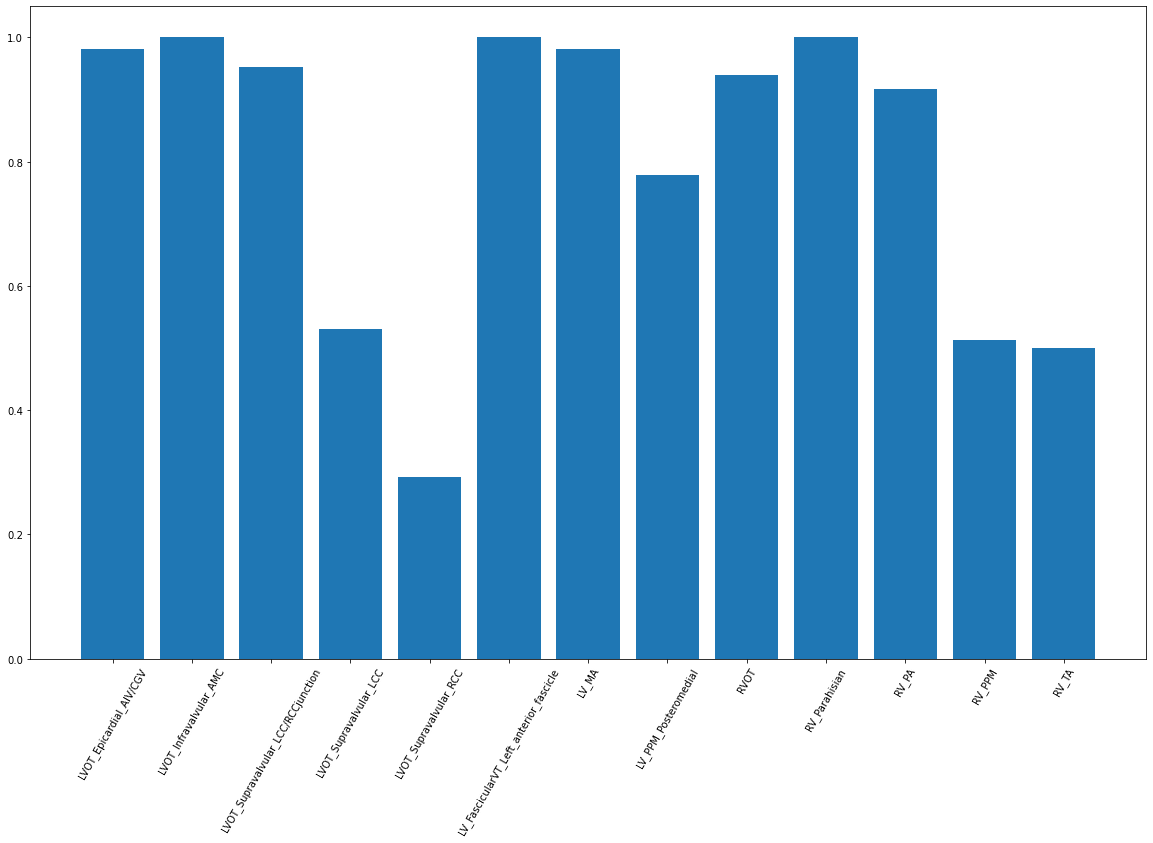

In [156]:
#plot accuracy across different location
threshould = 0.2
dic_total = {}
dic_correct = {}
dic_correct_rate = {}
for i in range(len(collect_ecg)):
    ori_location = collect_ecg[i][2]
    location = dic_2TPE[ori_location]
    label = collect_ecg[i][3]
    output = collect_ecg[i][4]
    if location in dic_total:
        dic_total[location] +=1
        if abs(label-output)<0.5:
            dic_correct[location]+=1
    else:  
        #initialiazation
        dic_correct_rate[location] = 0
        dic_total[location] = 0
        dic_correct[location] = 0
        #count the number
        dic_total[location] +=1
        if abs(label-output)<0.5:
            dic_correct[location]+=1
for location in dic_correct_rate:
    dic_correct_rate[location] = dic_correct[location]/dic_total[location]

print(dic_total)
print(dic_correct_rate)
plt.figure(figsize = (20,12))
plt.xticks(rotation = 60 )
plt.bar(dic_correct_rate.keys(),dic_correct_rate.values())

In [274]:
#use all wave
num_correct = 0
num_total = 0
#list to collecting result for ROC curve
collect_ecg = [] 
target=[]
predictions=[]
locations=[]
#count wave number distribution
count_LR=[0,0]
model.eval()
for i in range(len(test_data_loader)):
    list_ecg, list_label, location, file_name = test_data_loader[i]
    for k in range(len(list_ecg)):
        label = list_label[k].item()
        num_total+=1
        ecg = list_ecg[k]
        ecg = ecg[None,:,:,:]
        output = model(ecg.cuda())
        ecg = ecg[0,0,:,:]
        target.append(list_label[k].item())
        predictions.append(output.item()) #make prediction
        locations.append(location)
        #count wave type, L't or R't
        count_LR[label]+=1
        print(location , label-output.item())
        collect_ecg .append((ecg,file_name,location, label, output.item())) 

LVOT_Epicardial_AIV/CGV -0.004889426752924919
LVOT_Epicardial_AIV/CGV -0.0008495928486809134
LVOT_Epicardial_AIV/CGV -0.0042947037145495415
LVOT_Epicardial_AIV/CGV -0.004146702121943235
LVOT_Epicardial_AIV/CGV -0.0017730548279359937
LVOT_Epicardial_AIV/CGV -0.001449384493753314
LVOT_Epicardial_AIV/CGV -0.00309400144033134
LVOT_Epicardial_AIV/CGV -0.0033621436450630426
LVOT_Epicardial_AIV/CGV -0.003972828388214111
LVOT_Epicardial_AIV/CGV -0.003222475294023752
LVOT_Epicardial_AIV/CGV -0.002011395525187254
LVOT_Epicardial_AIV/CGV -0.0038985074497759342
LVOT_Epicardial_AIV/CGV -0.03754475712776184
LVOT_Epicardial_AIV/CGV -0.0011977547546848655
LVOT_Epicardial_AIV/CGV -0.0060134148225188255
LVOT_Epicardial_AIV/CGV -0.0005685100913979113
LVOT_Epicardial_AIV/CGV -0.000985069782473147
LVOT_Epicardial_AIV/CGV -0.010440056212246418
LVOT_Epicardial_AIV/CGV -0.008917832747101784
LVOT_Epicardial_AIV/CGV -0.00017844476678874344
LVOT_Epicardial_AIV/CGV -0.0004193479544483125
LVOT_Epicardial_AIV/CGV -

LVOT_Supravalvular_LCC -0.6920360922813416
LVOT_Supravalvular_LCC -0.6504508256912231
LVOT_Supravalvular_LCC -0.7277706861495972
LVOT_Supravalvular_LCC -0.964306116104126
LVOT_Supravalvular_LCC -0.9649766683578491
LVOT_Supravalvular_LCC -0.9359145760536194
LVOT_Supravalvular_LCC -0.01759389415383339
LVOT_Supravalvular_LCC -0.09551320970058441
LVOT_Supravalvular_LCC -0.025995047762989998
LVOT_Supravalvular_LCC -0.019682742655277252
LVOT_Supravalvular_LCC -0.058997742831707
LVOT_Supravalvular_LCC -0.032900165766477585
LVOT_Supravalvular_LCC -0.08937516808509827
LVOT_Supravalvular_LCC -0.05087803676724434
LVOT_Supravalvular_LCC -0.0711233988404274
LVOT_Supravalvular_LCC -0.03036123514175415
LVOT_Supravalvular_LCC -0.023402860388159752
LVOT_Supravalvular_LCC -0.03041614033281803
LVOT_Supravalvular_LCC -0.030905261635780334
LVOT_Supravalvular_LCC -0.818921685218811
LVOT_Supravalvular_LCC -0.7910202741622925
LVOT_Supravalvular_LCC -0.7018611431121826
LVOT_Supravalvular_LCC -0.875952959060669

RV_PPM 0.01072150468826294
RV_PPM 0.004287600517272949
RV_PPM 0.005241096019744873
RV_PPM 0.017880380153656006
RV_PPM 0.026112854480743408
RV_PPM 0.0041596293449401855
RV_PPM 0.056283414363861084
RV_PPM 0.018807411193847656
RV_PPM 0.004806995391845703
RV_PPM 0.029079973697662354
RV_PPM 0.008815109729766846
RV_PPM 0.033193111419677734
RV_PPM 0.0058699846267700195
RV_PPM 0.014683783054351807
RV_PPM 0.0069890618324279785
RV_PPM 0.008919060230255127
RV_PPM 0.0038213729858398438
RV_PPM 0.007793605327606201
RV_PPM 8.499622344970703e-05
RV_PPM 0.0007053613662719727
RV_PPM 0.003197789192199707
RV_PPM 0.00434720516204834
RV_PPM 0.127740740776062
RV_PPM 0.053614139556884766
RV_PPM 0.06544643640518188
RV_PPM 0.028295397758483887
RV_PPM 0.04032540321350098
RV_PPM 0.047351837158203125
RV_PPM 0.035201430320739746
RV_PPM 0.06325989961624146
RV_PPM 0.13643163442611694
RV_PPM 0.06669175624847412
RV_PPM 0.2808256149291992
RV_PPM 0.024511396884918213
RV_PPM 0.042777061462402344
RV_TA 0.9282929375767708
R

In [275]:
data = {}
for i , location in enumerate(locations):
    if location in data:
        data[location].append(predictions[i])
    else:  
        #initialiazation
        data[location] = []
        data[location].append(predictions[i])

LVOT_Epicardial_AIV/CGV
LVOT_Infravalvular_AMC
LVOT_Supravalvular_LCC/RCCjunction
LVOT_Supravalvular_LCC
LVOT_Supravalvular_RCC
LV_FascicularVT_Left_anterior_fascicle
LV_MA
LV_PPM_Posteromedial
RVOT
RV_Parahisian
RV_PA
RV_PPM
RV_TA


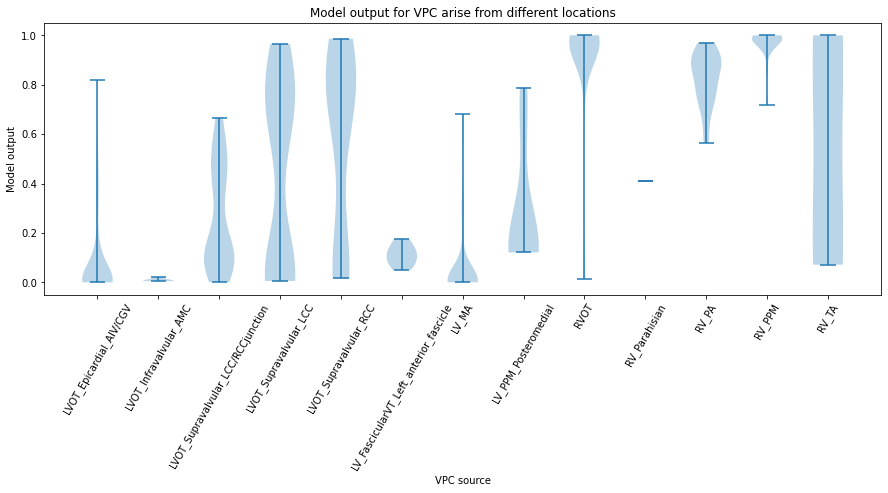

In [276]:
input_data = []
for key in data:
    print(key)
    input_data.append(data[key])
plt.figure(figsize=(15,5))
plt.violinplot(input_data)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13], ['LVOT_Epicardial_AIV/CGV', 'LVOT_Infravalvular_AMC', 'LVOT_Supravalvular_LCC/RCCjunction', 'LVOT_Supravalvular_LCC', 'LVOT_Supravalvular_RCC', 'LV_FascicularVT_Left_anterior_fascicle', 'LV_MA', 'LV_PPM_Posteromedial', 'RVOT', 'RV_Parahisian', 'RV_PA', 'RV_PPM', 'RV_TA'])
plt.xticks(rotation = 60 )
plt.title('Model output for VPC arise from different locations')
plt.xlabel('VPC source')
plt.ylabel('Model output')
plt.show()

In [277]:
data = {}
data['summit'] = []
data['cusp'] = []
data['Left chamber'] = []
data['RVOT'] = []
data['Right chamber'] = []
for i , location in enumerate(locations):
    if location == 'LVOT_Epicardial_AIV/CGV':
        data['summit'].append(predictions[i])
    elif (location == 'LVOT_Supravalvular_LCC/RCCjunction')| (location == 'LVOT_Supravalvular_LCC') | (location == 'LVOT_Supravalvular_NCC') | (location == 'LVOT_Supravalvular_RCC'):
        data['cusp'].append(predictions[i])
    elif (location == 'LVOT_Infravalvular_AMC')|(location == 'LV_FascicularVT_Left_anterior_fascicle')|(location == 'LV_MA')|(location == 'LV_PPM_Posteromedial'):
        data['Left chamber'].append(predictions[i])
    elif location == 'RVOT':
        data['RVOT'].append(predictions[i])
    elif (location == 'RV_Parahisian')|(location == 'RV_PA')|(location == 'RV_PPM')|(location == 'RV_TA'):
        data['Right chamber'].append(predictions[i])

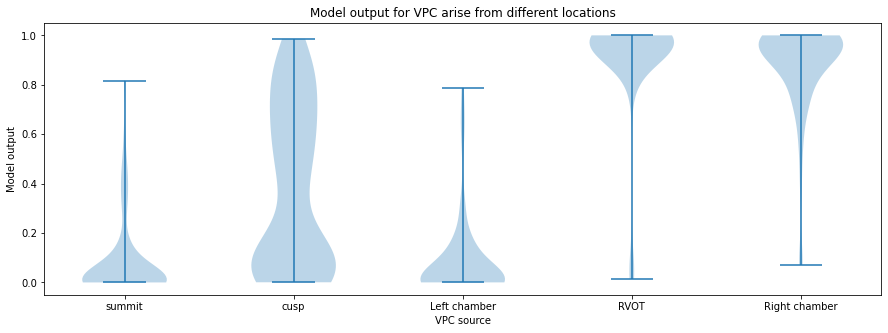

In [278]:
input_data = []
for key in data:
    input_data.append(data[key])
plt.figure(figsize=(15,5))
plt.violinplot(input_data)
plt.xticks([1,2,3,4,5], ['summit','cusp','Left chamber','RVOT','Right chamber'])
plt.title('Model output for VPC arise from different locations')
plt.xlabel('VPC source')
plt.ylabel('Model output')
plt.show()

### ROC plot

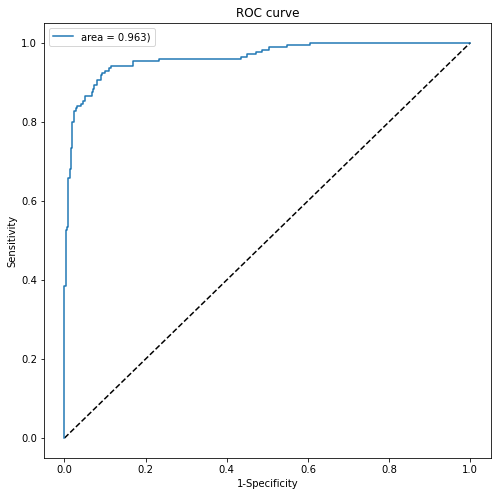

In [279]:
#view ROC curve, referance: https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(target, predictions)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(figsize=(8,8))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f})'.format(auc_keras))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()